# Task1 Data Generation
We created a Wechat group of **6 people**, where each person sent **50 WREs**, each containing **50r**, distributed to all 6 people.

That is to say, totally **300 i.i.d. samples from the hidden distribution**. $\mathbf{X}=(X_1,X_2,\dots,X_6),\; \sum_{i=1}^6 X_i=50$

# Task2 Data Processing
## Raw Info Collecting
We made use of an auto-test software **Airtest**(Based on Image Recognition) to traverse the ChatLog to get **Snapshots of WRE Reception Record Infos**.

![Airtest](./SupportImages/Airtest.png)

## Data Extracting and Processing
We deployed **gemma3:27b** model with **Ollama** on **WSL** and **Dify** with **Docker** on **Windows Host**. Gemma3 is able to **read images**.

Then we built a workflow on **Dify**, which is able to call **gemma3** to extract **Receiver Order Index** and **Receive Amount** from a **Snapshot**, and **structure-output a json file**.

![Dify](./SupportImages/Dify.png)

Then we wrote 3 python scripts:
- `DataExtractor.py` :
  -  Connect to Dify by its **API** 
  -  Upload a snapshot
  -  Get the returned json
- `DataProcessor.py` : 
  - Get input snapshots
  - Call DataExtractor.py in loops
  - Do postprocess and output data as a json file
- `Datavisualizer.py`
  - A **Scatter** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
  - A **Boxplot** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
  - 6 **Histograms** showing the distribution of each receiver with different **Receiver Order Index**'s receive amount   (*x:amount* - *y:frequency*)
  - 5 **Histograms** showing the distribution of each receiver with different **Receiver Order Index**'s receive amount **given the *most frequent sum inverval(narrow)*** of all previous received amounts. (*x:amount* - *y:frequency*)

## Code

In [16]:
import requests
import json
import os
import mimetypes
import glob
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]

### DataExtractor

In [17]:
# ====== Configuration ======
LOCAL_DIFY_URL = "http://localhost"
API_KEY = "app-5Wjz73iI02lHt23TiDULPkIL"
USER_ID = "PositionZero"


def upload_file(file_path, user, base_url, api_key):
    upload_url = f"{base_url}/v1/files/upload"
    headers = {
        "Authorization": f"Bearer {api_key}",
    }

    try:
        with open(file_path, "rb") as file:
            mime_type, _ = mimetypes.guess_type(file_path)
            if not mime_type:
                mime_type = "application/octet-stream"

            files = {"file": (os.path.basename(file_path), file, mime_type)}
            data = {"user": user}

            response = requests.post(
                upload_url, headers=headers, files=files, data=data, timeout=60
            )
            if response.status_code == 201 or response.status_code == 200:
                return response.json()
            else:
                print(f"❌ 文件上传失败，状态码: {response.status_code}")
                try:
                    print(response.json())
                except:
                    print(response.text)
                return None
    except Exception as e:
        print(f"❌ 上传发生错误: {str(e)}")
        return None


def run_workflow(file_id, user, base_url, api_key, response_mode="blocking"):
    workflow_url = f"{base_url}/v1/workflows/run"
    headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}

    data = {
        "inputs": {
            "RedPacketInfo": {
                "transfer_method": "local_file",
                "upload_file_id": file_id,
                "type": "image",
            }
        },
        "response_mode": response_mode,
        "user": user,
    }

    try:
        response = requests.post(workflow_url, headers=headers, json=data, timeout=120)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"❌ 工作流执行失败，状态码: {response.status_code}")
            try:
                print(response.json())
            except:
                print(response.text)
            return {
                "status": "error",
                "message": f"Failed to execute workflow, status code: {response.status_code}",
            }
    except Exception as e:
        print(f"❌ 运行发生错误: {str(e)}")
        return {"status": "error", "message": str(e)}


def extract_data_from_image(
    image_path, user_id=USER_ID, base_url=LOCAL_DIFY_URL, api_key=API_KEY
):
    if not os.path.exists(image_path):
        print(f"❌ 找不到图片文件，请检查路径：{image_path}")
        return None

    upload_resp = upload_file(image_path, user_id, base_url, api_key)

    if upload_resp and "id" in upload_resp:
        file_id = upload_resp["id"]

        run_resp = run_workflow(file_id, user_id, base_url, api_key)

        # 解析 run 响应以提取 outputs
        run_output = None
        if (
            isinstance(run_resp, dict)
            and "data" in run_resp
            and isinstance(run_resp["data"], dict)
            and "outputs" in run_resp["data"]
        ):
            run_output = run_resp["data"]["outputs"]
        else:
            run_output = run_resp

        try:
            text_content = run_output.get("text")
            if "```json" in text_content:
                text_content = text_content.replace("```json", "").replace("```", "")

            parsed_json = json.loads(text_content)

            # Attempt to locate the list of items
            info = None
            if isinstance(parsed_json, dict):
                # 1. Try exact match
                if "red_packets" in parsed_json:
                    info = parsed_json["red_packets"]
                # 2. Search for any list value if specific key is missing
                else:
                    for key, value in parsed_json.items():
                        if isinstance(value, list):
                            info = value
                            break
            elif isinstance(parsed_json, list):
                # 3. The root object itself is the list
                info = parsed_json

            if info is None:
                raise ValueError("Cannot locate a valid data list in response.")

            data = []
            for i in range(len(info) - 1, -1, -1):
                amount_str = info[i].get("ReceiveAmount", "0")
                amount_str = str(amount_str).replace("元", "")
                data.append(float(amount_str))
            return data
        except Exception as e:
            print(f"Error parsing data: {e}")
            return None

    else:
        print("文件上传失败，无法执行工作流")
        return None


### DataProcessor

In [18]:
OUTPUT_DIR = "Output/"  # Temporary output directory for test-generated data
DATABASE_DIR = "Database/"  # Acknowledged and manually transferred long-term data storage from OUTPUT_DIR

def process_all_snapshots():
    # Cleanup: Delete all temp generated .jpgs in Snapshots/
    jpg_files = glob.glob(os.path.join("Snapshots", "*.jpg"))
    if jpg_files:
        for f in jpg_files:
            try:
                os.remove(f)
            except Exception as e:
                print(f"Failed to delete {f}: {e}")

    snapshot_files = glob.glob(os.path.join("Snapshots", "info*.png"))

    snapshot_files.sort()

    data = []

    for file_path in snapshot_files:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        file_data = extract_data_from_image(file_path)

        if file_data:
            data.append(file_data)
        else:
            print(f"Failed to extract data from {file_path}")

    if not data:
        print("No data collected.")
        return

    # Save data to a JSON
    output_json_path = os.path.join(OUTPUT_DIR, "Wechat_Samples.json")

    try:
        with open(output_json_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=4)
    except Exception as e:
        print(f"Error saving data to file: {e}")


### DataVisualizer

In [19]:
def visualize_data(data):
    plt.figure(figsize=(12, 6))

    # Data logic for plotting
    # Example: data = [[A1, B1], [A2, B2], [A3, B3]]
    # Index 0 (A): Values (A1, A2, A3)
    # Index 1 (B): Values (B1, B2, B3)

    # Determine maximum dimension length
    max_len = max(len(d) for d in data) if data else 0

    # 1. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    # 1. Prepare data by dimension
    data_by_dimension = []
    for dim_idx in range(max_len):
        values = [snap[dim_idx] for snap in data if dim_idx < len(snap)]
        data_by_dimension.append(values)

    # 2. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    for dim_idx, values in enumerate(data_by_dimension):
        if values:
            # Add random jitter to x coordinates
            jitter = np.random.uniform(-0.1, 0.1, len(values))
            x = np.array([dim_idx] * len(values)) + jitter

            plt.scatter(
                x,
                values,
                alpha=0.6,
                s=50,
                label=f"Dim {dim_idx}" if dim_idx == 0 else "",
            )

    plt.title("All Value Distribution (Scatter)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.xticks(range(max_len))
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # 3. Overlay Plot: Vertical Boxplot (Index vs Value)
    plt.figure(figsize=(12, 6))
    plt.boxplot(data_by_dimension, tick_labels=range(max_len))

    plt.title("All Value Distribution (Boxplot)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # 4. Individual Plots: Histogram (Value Distribution)
    for dim_idx, values in enumerate(data_by_dimension):
        if not values:
            continue

        plt.figure(figsize=(10, 6))

        plt.hist(values, bins=20, color="teal", alpha=0.7, edgecolor="black")

        plt.title(f"Distribution Histogram for Receiver # {dim_idx}")
        plt.xlabel("Value (元)")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()
    # Generate conditional histograms
    visualize_conditional_histograms(data)


def visualize_conditional_histograms(data):
    max_len = max(len(d) for d in data) if data else 0

    # k corresponds to dimensions X_k where k > 1 (1-based) => indices 1, 2, ...
    for dim_idx in range(1, max_len):
        pairs = []
        for sample in data:
            if dim_idx < len(sample):
                # Sum of previous dimensions X_0 ... X_{k-1}
                prev_sum = sum(sample[:dim_idx])
                val = sample[dim_idx]
                pairs.append((prev_sum, val))

        if not pairs:
            continue

        sums = [p[0] for p in pairs]

        # Determine the most frequent interval (mode) for the sums
        if not sums:
            continue

        # Use bins='auto' or a fixed number large enough to validly capture the peak
        counts, bin_edges = np.histogram(sums, bins="auto")
        if len(counts) == 0:
            continue

        max_bin_idx = np.argmax(counts)
        range_min = bin_edges[max_bin_idx]
        range_max = bin_edges[max_bin_idx + 1]

        # Filter X_k where sum is in this interval
        # Note: np.histogram includes right edge for the last bin, but generally [a, b)
        # We will use the edges directly.
        filtered_values = [val for s, val in pairs if range_min <= s <= range_max]

        if not filtered_values:
            continue

        plt.figure(figsize=(10, 6))
        plt.hist(filtered_values, bins=20, color="purple", alpha=0.7, edgecolor="black")

        plt.title(
            f"Hist for X_{dim_idx} | Sum(X_0..X_{dim_idx-1}) in [{range_min:.2f}, {range_max:.2f}]"
        )
        plt.xlabel(f"X_{dim_idx} Value")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

### Main

Loading data from Database/Wechat_Samples.json...


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

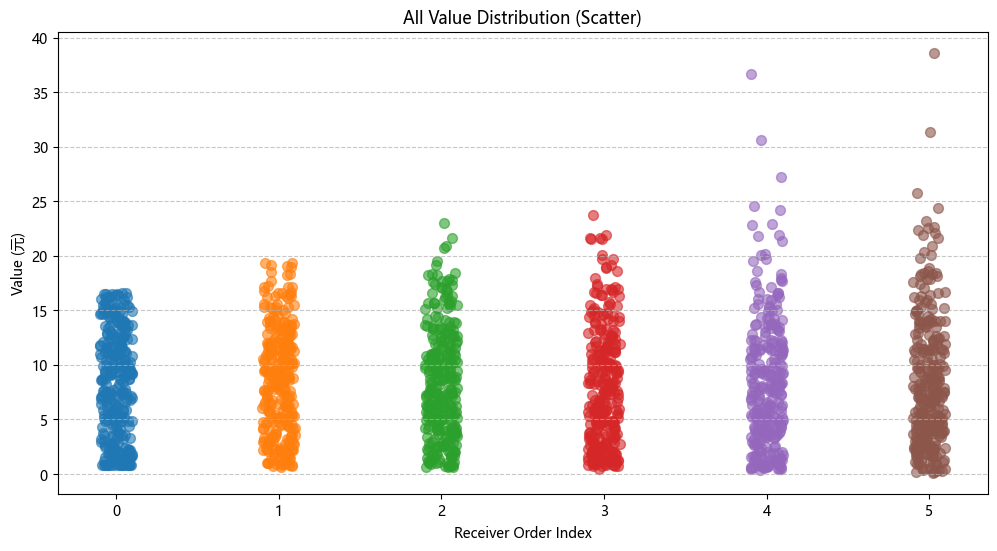

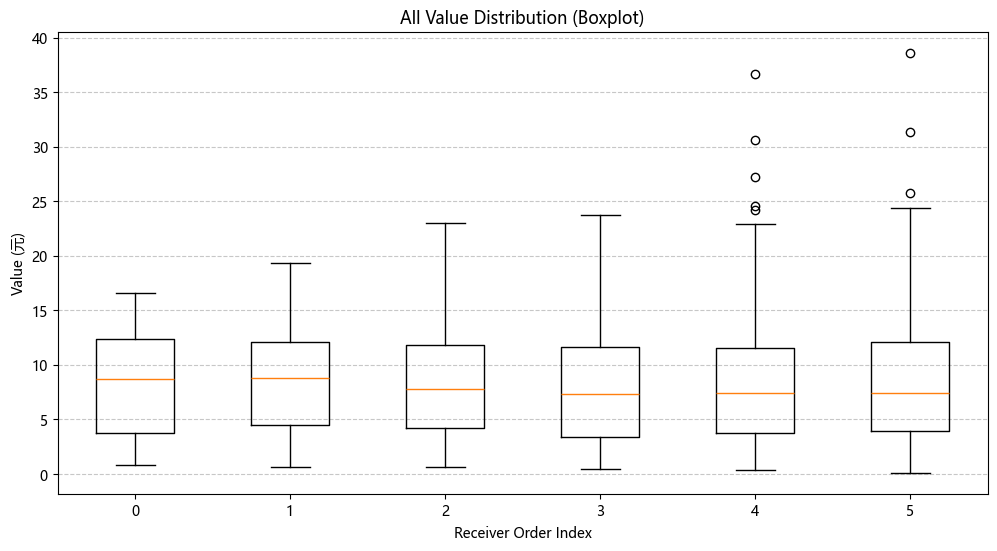

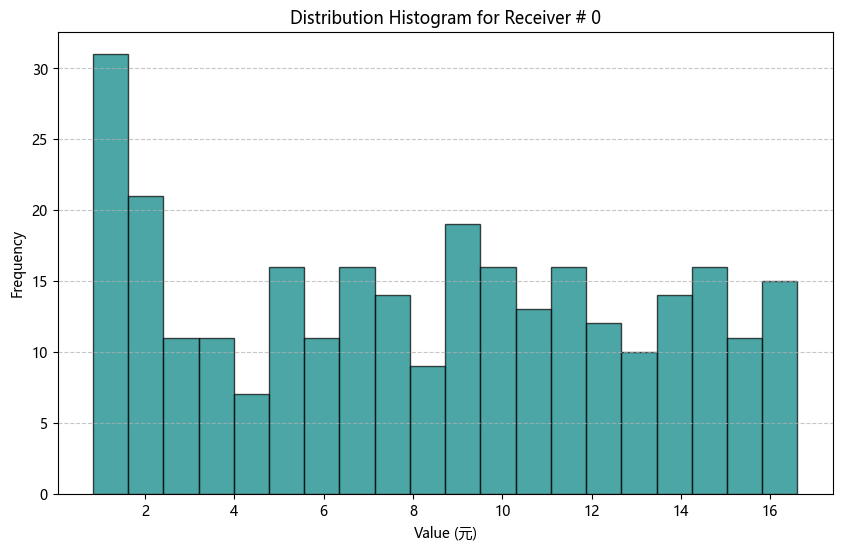

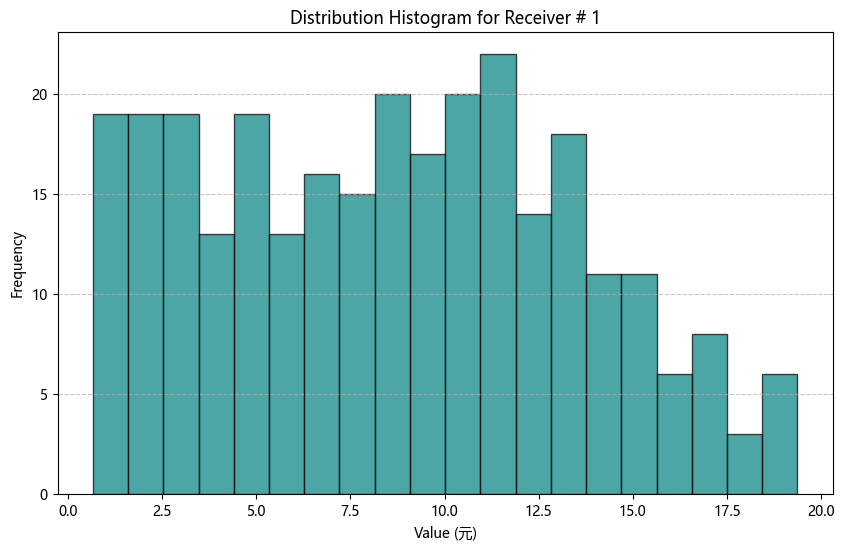

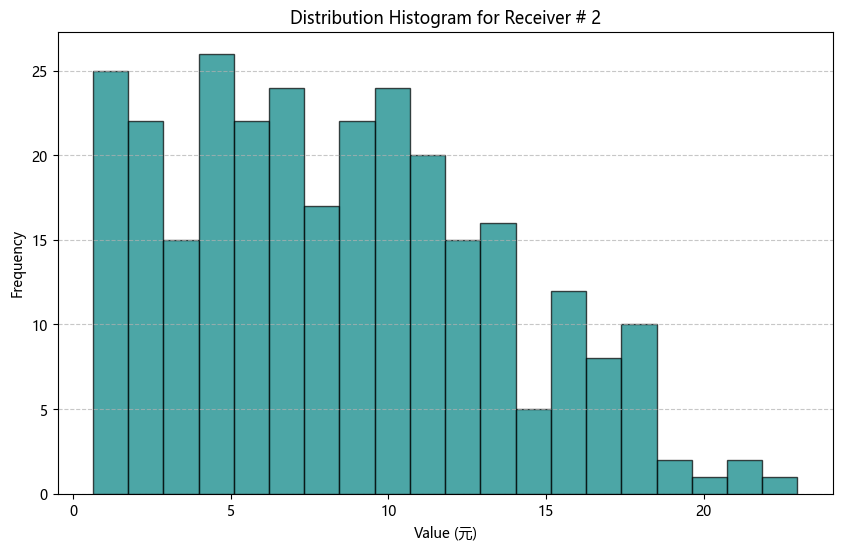

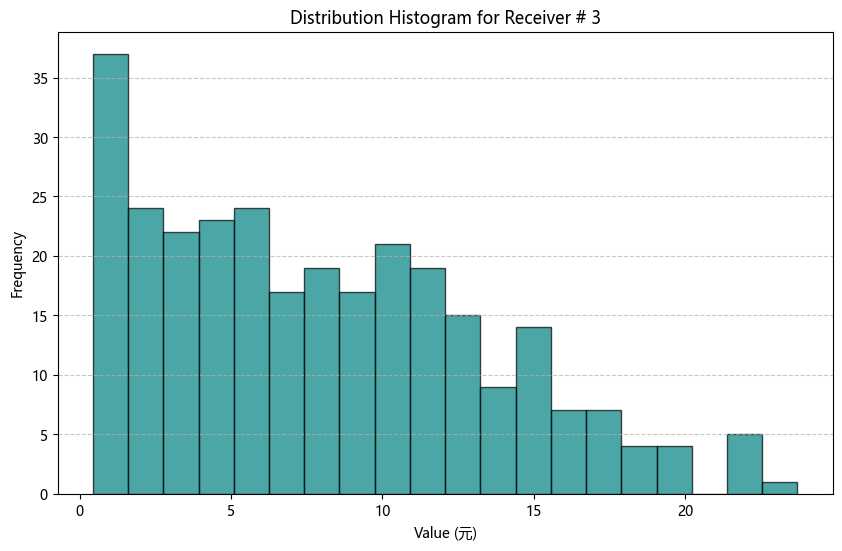

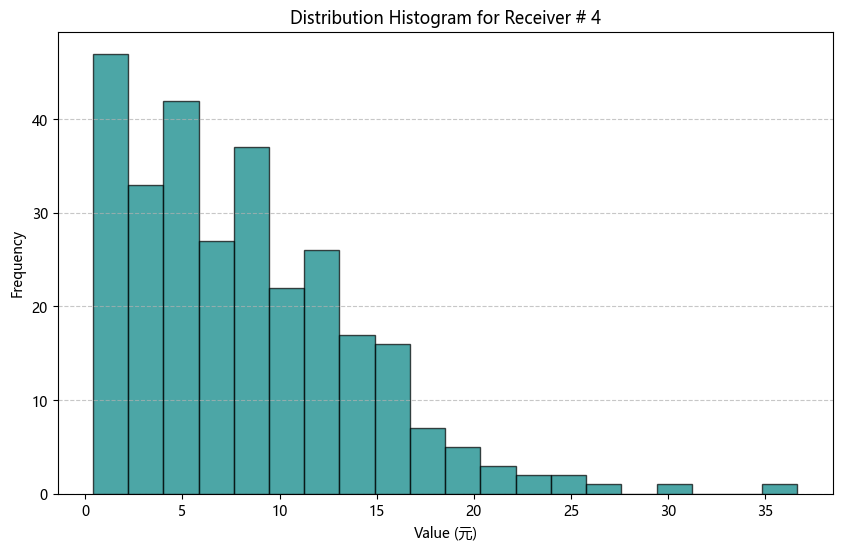

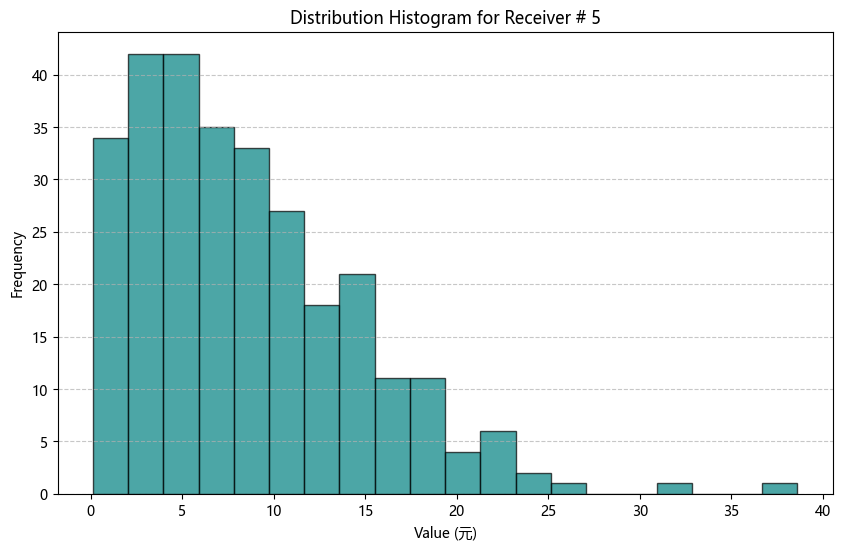

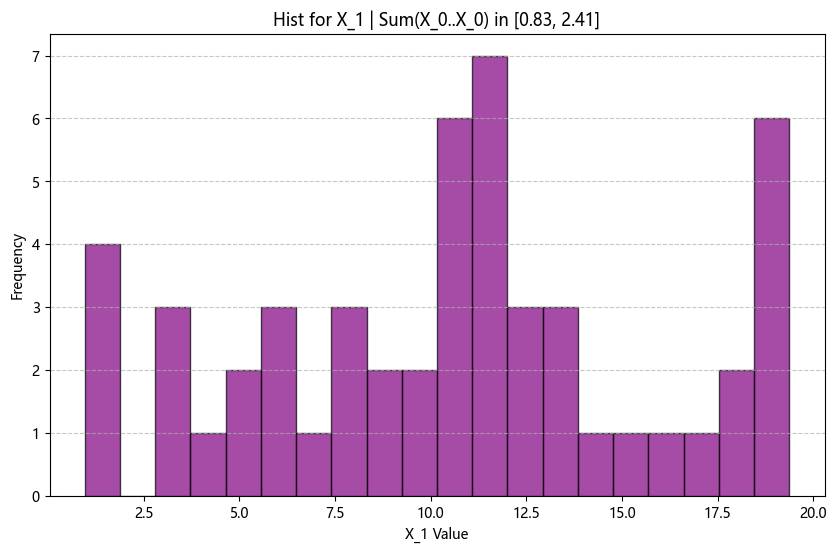

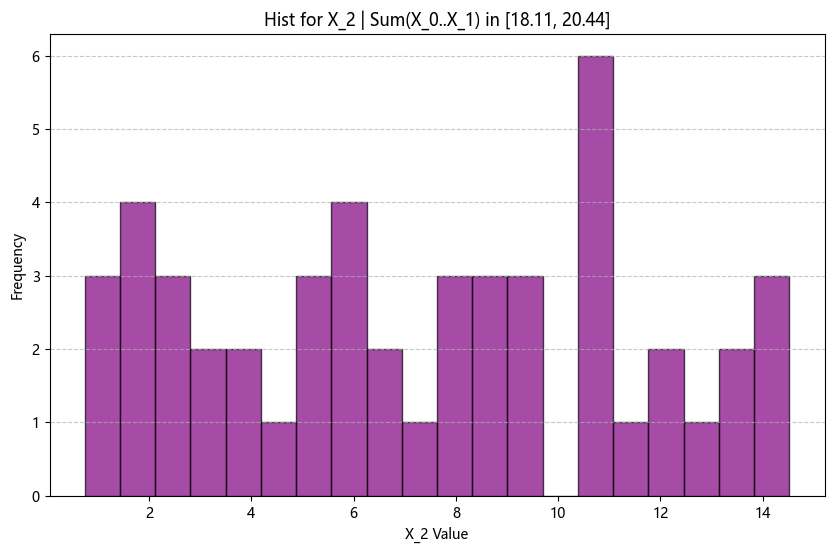

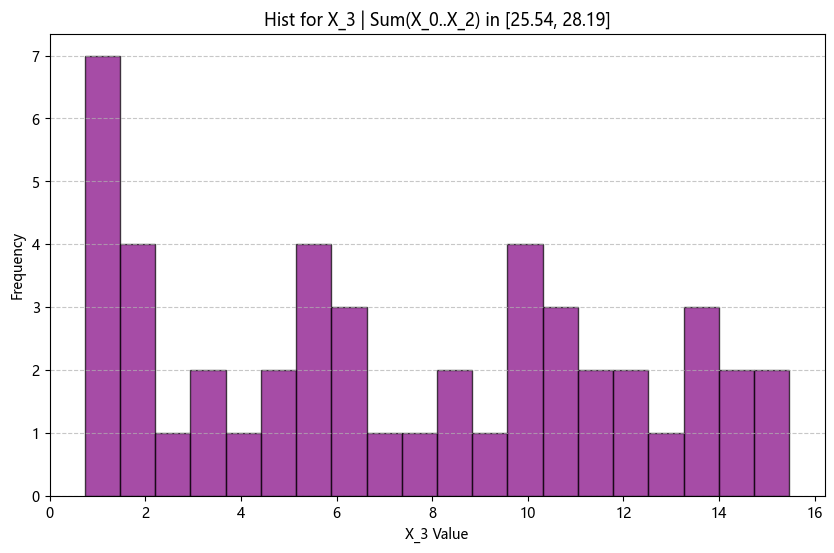

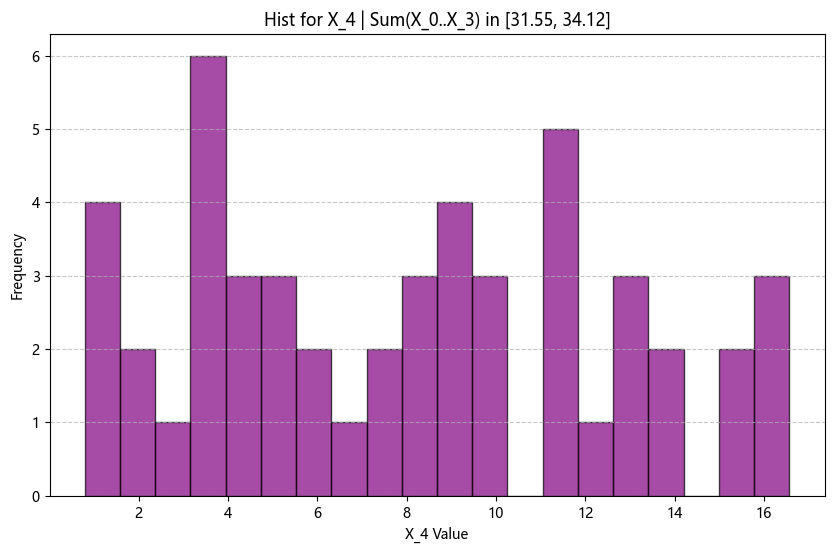

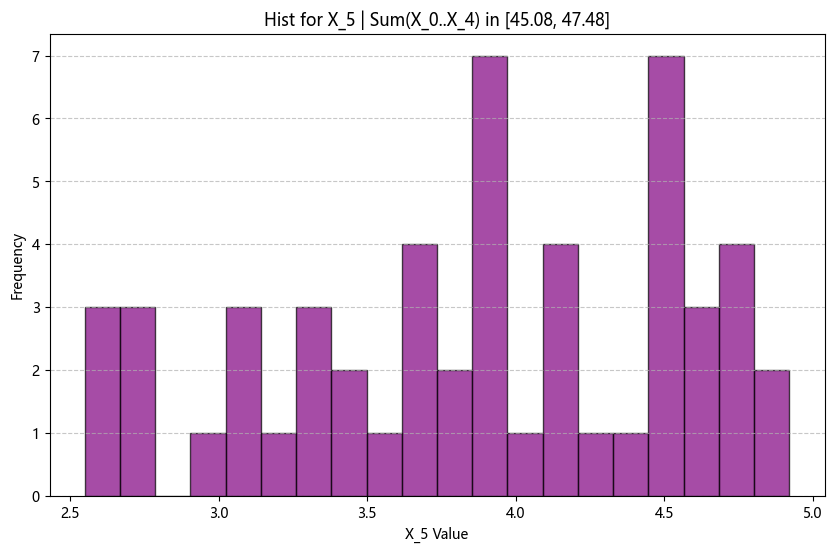

In [20]:
# Load Wechat_Samples.json if it exists, otherwise process snapshots
data_path = os.path.join(DATABASE_DIR, "Wechat_Samples.json")

if os.path.exists(data_path):
    print(f"Loading data from {data_path}...")
    try:
        with open(data_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        visualize_data(data)
    except Exception as e:
        print(f"Error loading data from file: {e}")
        print("Falling back to processing snapshots...")
        process_all_snapshots()
else:
    process_all_snapshots()

# Task5 Diffusion Model

- `DiffusionModelTrainer.py` Using the 300 samples from Wechat, we trained a **DDPM(Denoising Diffusion Probabilistic Model)**.
- `NewSampleGenerator.py` We used the trained model to generate new sample sets.
- `DistuibutionEvaluator.py` We used ***Peacock's Algorithm (Multidimensional KS Test)*** and ***Energy Distance*** to determine that the 2 sets are from the same hidden distuibution.
- Since we have varified that the generated samples are indeed **from the target distribution**, we can use them as reference to build our model.
  Such model would be much more reasonable since the generated set has a **much larger size**.
- `DataVisualizer.py` Draw similar plots for the generated sample set, with the **much larger set size** to have a better visualization.


## DDPM
- ### Forward Process
  
  ***Objective***: Gradually add **Gaussian Noise** to a ***normalized*** sample $\mathbf{X}_0$ to get nearly pure noise $\mathbf{X}_t$.
  
  **For DDPM**, the process is a **Markov Chain**.
  
  Given parameters $\epsilon \sim \mathcal{N}(0,1)$ and $\beta_t \in (0,1)$
  $$\mathbf{X}_{t+1} = \sqrt{1-\beta_t} \cdot \mathbf{X}_t+\beta_t \cdot \epsilon \Rightarrow \lim_{t\rightarrow \infty} \mathbf{X}_t \sim \mathcal{N}(0,1)$$

  Let $\alpha_t=1-\beta_t, \; \bar{\alpha}_t=\prod_{i=1}^t \alpha_i$, we have:
  $$\mathbf{X}_t = \sqrt{\bar{\alpha}_t} \cdot \mathbf{X}_0 + (1-\bar{\alpha}_t) \cdot \epsilon$$

  or more commonly seen in the form of PDF as: $$q(\mathbf{x}_t\mid \mathbf{x}_0) = \sqrt{\bar{\alpha}_t} \cdot \mathbf{x}_0 + (1-\bar{\alpha}_t) \cdot \epsilon$$

- ### Reverse Process (Denoise)
  
  ***Objective***: Train a **Neural Network** to rebuild data from **Gaussian Noise** $\mathbf{X}_T$.

  The rebuilding process is also a **Markov Chain**. 
  
  Denote $\mathbf{X}_{a:b}$ as the joint distribution of $\mathbf{X}_a,\mathbf{X}_{a+1},\dots ,\mathbf{X}_b$, we have:
  $$ p_\theta(\mathbf{x}_{0:T})= p_\theta(\mathbf{x}_T)\prod_{t=1}^T p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t)$$

  ***Training Objective***: Maximize ***negative log-likelihood*** of generating the real sample $\mathbf{X}_0$.
  $$\theta=\arg\max_\theta (-\log p_\theta(\mathbf{x}_0))$$

  Since it's ***intractable*** to calculate integral of the joint PDF to get $p_\theta(\mathbf{x}_0)$, we calculate the **Evidence Lower Bound(ELBO)**,

  which is the expectation below.
  ![ELBO](./SupportImages/ELBO.png "Derivation of ELBO")

  Then the ELBO can be transformed and simplized to the form below.
  $$-\mathbb{E}_q[\sum_{t>1}D_{KL}(r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0) || p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t))]$$
  where $r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0)$ is called the ***true posterior*** since it's conditioned on $\mathbf{x}_0$ in extra, and it has a ***closed-form expression*** we can compute.
  $$r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0) = \mathcal{N}(\tilde{\mu}_t,\tilde{\beta}_t)$$

  $D_{KL}$ is called the ***KL-Divergence*** which can evaluate **how close** 2 distribution is.

  Therefore, during training, our objective is to ***minimize the distance*** of each **estimated posterior** $p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t)$ to the **true posterior** $r(\mathbf{x}_{t-1}\mid \mathbf{x}_t,\mathbf{x}_0)$.

  Since we have a theorem says **reverse of a Gaussian Markov is also Gaussian**, we set:
  $$p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t) = \mathcal{N}(\mu_\theta,\sigma_t)$$

  In this case, $D_{KL}$ can be simplized to $L^2$ norm:
  $$D_{KL}=\frac{1}{2\sigma_t^2} ||\tilde{\mu}_t-\mu_\theta(\mathbf{x}_t,t)||^2$$

  Given the expression of $\tilde{\mu}_t$ and $\mu_\theta(\mathbf{x}_t,t)$:
  $$\tilde{\mu}_t=\frac{1}{\sqrt{\alpha_t}}(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\cdot \epsilon) \qquad 
  \mu_\theta(\mathbf{x}_t,t)=\frac{1}{\sqrt{\alpha_t}}(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\cdot \epsilon_\theta(\mathbf{x}_t,t))$$
  where $\epsilon_\theta(\mathbf{x}_t,t)$ is the **estimate of noise** added to $\mathbf{X}_0$ to produce $\mathbf{X}_t$

  We have our final ***Loss Function***:
  $$\mathcal{L}=\mathbb{E}_q[\sum_{t>1}\frac{\beta_t^2}{2\sigma_t^2\alpha_t(1-\bar{\alpha}_t)}||\epsilon-\epsilon_\theta(\mathbf{x}_t,t)||^2]$$

  (Credit to @Deepia-ls2fo https://www.youtube.com/watch?v=EhndHhIvWWw)



## Peacock's Algorithm (Multidimensional KS Test)

**Peacock's Algorithm** (and its generalization by Fasano & Franceschini) is a **multidimensional extension of the Kolmogorov-Smirnov (KS) test**.

In 1D, the KS test finds the maximum vertical distance between the CDFs of two datasets.
$$ D = \sup_x |F_1(x) - F_2(x)| $$

In $\mathbb{R}^d$ for $d > 1$, the notion of "Cumulative Distribution" is not unique because there is no natural ordering of points. Peacock's Approach solves this by defining the CDF in terms of **orthants** (multidimensional quadrants).

For a point $\mathbf{p}$ and a dataset, we calculate the fraction of data points in each of the $2^d$ orthants centered at $\mathbf{p}$. The statistic is the **maximum absolute difference** in these fractions between the generated and real datasets, minimized over all reference points.

$$ D_n = \sup_{\mathbf{p} \in \mathbb{R}^d} \max_{\text{orthants } \mathcal{O}} | P_1(\mathbf{p}, \mathcal{O}) - P_2(\mathbf{p}, \mathcal{O}) | $$

This metric is sensitive to differences in both **location** and **shape** of the distributions. A low value (close to 0) indicates the distributions are similar. We use the Fasano-Franceschini approximation which iterates over data points as reference centers to make it computationally feasible.

## Energy Distance

**Energy Distance** is a statistical distance between the probability distributions of random vectors, which characterizes equality of distributions.

For two independent random vectors $\mathbf{X}$ (from the real dataset) and $\mathbf{Y}$ (from our generated dataset) with CDFs $F$ and $G$, the energy distance is defined as:

$$ D^2(F, G) = 2\mathbb{E}||\mathbf{X} - \mathbf{Y}|| - \mathbb{E}||\mathbf{X} - \mathbf{X}'|| - \mathbb{E}||\mathbf{Y} - \mathbf{Y}'|| $$

where:
* $\mathbb{E}||\mathbf{X} - \mathbf{Y}||$ is the average Euclidean distance between points in the real set and points in the generated set.
* $\mathbb{E}||\mathbf{X} - \mathbf{X}'||$ is the average distance between points within the real set.
* $\mathbb{E}||\mathbf{Y} - \mathbf{Y}'||$ is the average distance between points within the generated set.

**Key Properties**:
1. **$D^2(F, G) = 0$ if and only if $F = G$**.
2. It is **rotation invariant**, meaning it works equally well regardless of how the dimensions are oriented.
3. It effectively captures differences in the "energy" or potential of the distributions. 

We perform a **Permutation Test** on the Energy Distance to obtain a p-value, which tells us if the observed difference is statistically significant. A high p-value ($> 0.05$) generally suggests we cannot distinguish the two distributions, implying our model generated high-quality samples.

## Practical Implementation Optimizations
### Simplified Loss Function
In practice (as in our `DiffusionModelTrainer.py` and in DDPM's original paper), we used the **Simplified Loss(MSE)**.
   $$ \mathcal{L}_{\text{simple}} = \mathbb{E}_{t, \mathbf{x}_0, \epsilon} [||\epsilon - \epsilon_\theta(\mathbf{x}_t, t)||^2] $$

This involves two key changes:
1. **Replacing Sum with Expectation (Stochastic Sampling)**:
   The theoretical calculation requires a sum over all time steps: $\mathcal{L} = \sum_{t=1}^T L_t$.
   
   Mathematically, a sum is equivalent to an expectation over a uniform distribution scaled by a constant:
   $$ \sum_{t=1}^T L_t = T \cdot \mathbb{E}_{t \sim \mathcal{U}(1,T)}[L_t] $$
   
   Therefore, instead of computing the forward/backward pass for **all 1000 steps** for every single sample (which is computationally expensive), we **randomly sample one $t$** for each sample in the batch.
2. **Discarding Weighting Coefficients**:
   Neglecting the weighting term down-weights the loss at small $t$ (where noise is small), encouraging the model to focus on more difficult, noisier steps ($t$ large), which **empirically(as in the original paper)** improves sample quality.

### $n-1$ Degrees of Freedom
Since the total amount of each WRE is a **fixed** 50r, $df=6-1=5$, during training, we only consider **the first 5 dimensions** of each sample, then when generating new samples, the 6th dimension is the amount left, by which we can ensure that for each sample, all dimensions' **value sum to 50**.


## Code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as ssd

# ===== Configuration =====
DATABASE_DIR = "Database"
DATA_PATH = os.path.join(DATABASE_DIR, "Wechat_Samples.json")
MODEL_DIR = "DiffusionModel"

# NewSampleGenerator Paths
MODEL_PATH = os.path.join(MODEL_DIR, "diffusion_model.pth")
STATS_PATH = os.path.join(MODEL_DIR, "model_stats.json")
OUTPUT_PATH = os.path.join(DATABASE_DIR, "DDPM_Generated_Samples.json")

# Training Config
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 1000
TIMESTEPS = 1000
BETA_START = 1e-4
BETA_END = 0.02
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 5
HIDDEN_DIM = 128

# Generation Config
NUM_SAMPLES = 1000000

### DiffusionModelTrainer

In [ ]:
# ===== Dataset and Data Loading =====
class WechatDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path, "r") as f:
            data = json.load(f)
        self.data = torch.tensor(data, dtype=torch.float32)

        # Keep only first 5 dimensions
        if self.data.shape[1] > 5:
            self.data = self.data[:, :5]

        # Normalization
        self.mean = self.data.mean(dim=0)
        self.std = self.data.std(dim=0)
        self.normalized_data = (self.data - self.mean) / (self.std + 1e-8)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.normalized_data[idx]


# ===== Model Components =====
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Main network
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        self.mid_layers = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.final_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        # Embed time
        t_emb = self.time_mlp(t)

        # Embed input
        x_emb = self.input_layer(x)

        # Concatenate x embedding and time embedding
        # Note: We concatenate them or add them. Concatenating to input of interaction layers is common.
        # Here we concat along feature dimension
        h = torch.cat([x_emb, t_emb], dim=1)

        h = self.mid_layers(h)
        return self.final_layer(h)


# ===== Training Logic =====
def get_beta_schedule(timesteps, start, end):
    return torch.linspace(start, end, timesteps)


def train():
    # 1. Prepare Data
    if not os.path.exists(DATA_PATH):
        print(f"Error: Database file not found at {DATA_PATH}")
        return

    dataset = WechatDataset(DATA_PATH)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 2. Diffusion Setup
    betas = get_beta_schedule(TIMESTEPS, BETA_START, BETA_END).to(DEVICE)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    # 3. Model Setup
    model = DiffusionModel(INPUT_DIM, HIDDEN_DIM).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    # 4. Training Loop
    model.train()
    loss_history = []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(DEVICE)

            # Sample t uniformly
            t = torch.randint(0, TIMESTEPS, (batch.size(0),), device=DEVICE).long()

            # Sample noise
            noise = torch.randn_like(batch)

            # Forward diffusion q(x_t | x_0)
            # x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
            sqrt_alpha_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None]
            sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alphas_cumprod[t])[:, None]

            x_t = sqrt_alpha_cumprod_t * batch + sqrt_one_minus_alpha_cumprod_t * noise

            # Predict noise
            noise_pred = model(x_t, t)

            # Loss
            loss = criterion(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)

    # 5. Save Model and Stats
    os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
    
    torch.save(model.state_dict(), MODEL_PATH)
    # Save normalization stats for generation later
    stats = {"mean": dataset.mean.tolist(), "std": dataset.std.tolist()}
    with open(STATS_PATH, "w") as f:
        json.dump(stats, f)

    # 6. Visualize Loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Evolution of Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### NewSampleGenerator

In [ ]:
def sample(model, num_samples):
    model.eval()
    with torch.no_grad():
        # 1. Prepare betas and alphas
        # Ensure we use the same schedule as training
        betas = get_beta_schedule(TIMESTEPS, BETA_START, BETA_END).to(DEVICE)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)

        # 2. Initialize x_T with random noise
        # Start from pure Gaussian noise
        x = torch.randn((num_samples, INPUT_DIM)).to(DEVICE)

        # 3. Iterative denoising
        for t in reversed(range(TIMESTEPS)):

            # Create a batch of time steps
            t_tensor = torch.full((num_samples,), t, device=DEVICE, dtype=torch.long)

            # Predict noise using the model
            predicted_noise = model(x, t_tensor)

            # Get coefficients for this time step
            alpha = alphas[t]
            alpha_cumprod = alphas_cumprod[t]
            beta = betas[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            # Compute x_{t-1} using the reverse diffusion formula
            # x_{t-1} = (1/sqrt(alpha)) * (x_t - ((1-alpha)/sqrt(1-alpha_cumprod)) * eps) + sigma * z

            inv_sqrt_alpha = 1 / torch.sqrt(alpha)
            noise_coeff = (1 - alpha) / torch.sqrt(1 - alpha_cumprod)
            sigma = torch.sqrt(beta)  # Using sigma_t^2 = beta_t

            x = inv_sqrt_alpha * (x - noise_coeff * predicted_noise) + sigma * noise

    return x


def generate_samples(num_samples=NUM_SAMPLES, output_file=OUTPUT_PATH):
    # Check if model exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at {MODEL_PATH}")
        print("Please train the model first using DiffusionModelTrainer.py")
        return

    # Initialize Model
    model = DiffusionModel(INPUT_DIM, HIDDEN_DIM).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

    # Load Normalization Stats
    if os.path.exists(STATS_PATH):
        with open(STATS_PATH, "r") as f:
            stats = json.load(f)
        mean = torch.tensor(stats["mean"]).to(DEVICE)
        std = torch.tensor(stats["std"]).to(DEVICE)
    else:
        print(f"Error: Stats file not found at {STATS_PATH}")
        return

    # Generate
    generated_data_norm = sample(model, num_samples)

    # Denormalize
    # x = x_norm * std + mean
    generated_data = generated_data_norm * (std + 1e-8) + mean

    # Calculate 6th dimension: 50 - sum(first 5 dims)
    # This was trained as 5D model with 6th dim inferred
    dim6 = 50.0 - torch.sum(generated_data, dim=1, keepdim=True)
    generated_data = torch.cat([generated_data, dim6], dim=1)

    # Save to JSON
    generated_list = generated_data.cpu().numpy().tolist()

    # Round floats to 2 decimal places
    rounded_list = [[round(float(v), 2) for v in row] for row in generated_list]

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, "w") as f:
        json.dump(rounded_list, f, indent=4)

### DistributionEvaluator

In [ ]:
# Set seed for reproducibility
np.random.seed(0xF114514)

def load_data(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    return np.array(data)


def energy_distance(u, v):
    """
    Compute the energy distance between two distributions u and v.
    d^2(u, v) = 2 E||u - v|| - E||u - u'|| - E||v - v'||

    If inputs are very large, we subsample to keep computation feasible.
    """
    # Subsample if too large to avoid O(N^2) memory/time issues
    # Limit to e.g. 2000 samples for the distance matrix calculation
    max_samples = 2000

    if len(u) > max_samples:
        indices = np.random.choice(len(u), max_samples, replace=False)
        u = u[indices]

    if len(v) > max_samples:
        indices = np.random.choice(len(v), max_samples, replace=False)
        v = v[indices]

    # Efficient pairwise distance calculation
    d_uv = ssd.cdist(u, v, "euclidean")
    d_uu = ssd.cdist(u, u, "euclidean")
    d_vv = ssd.cdist(v, v, "euclidean")

    E_uv = np.mean(d_uv)
    E_uu = np.mean(d_uu)
    E_vv = np.mean(d_vv)

    result = 2 * E_uv - E_uu - E_vv
    return result


def energy_distance_permutation_test(u, v, n_permutations=100):
    """
    Perform a permutation test to get a p-value for the Energy Distance.
    H0: u and v are from the same distribution.
    """
    # Subsample for speed if needed (keep consistent with energy_distance call)
    max_samples = 1000  # smaller for permutation loop
    if len(u) > max_samples:
        u = u[np.random.choice(len(u), max_samples, replace=False)]
    if len(v) > max_samples:
        v = v[np.random.choice(len(v), max_samples, replace=False)]

    n_u = len(u)
    n_v = len(v)
    combined = np.vstack([u, v])

    # Precompute distance matrix
    d_mat = ssd.cdist(combined, combined, "euclidean")

    def get_e_stat(indices_u, indices_v):
        d_uu = d_mat[np.ix_(indices_u, indices_u)]
        d_vv = d_mat[np.ix_(indices_v, indices_v)]
        d_uv = d_mat[np.ix_(indices_u, indices_v)]

        return 2 * np.mean(d_uv) - np.mean(d_uu) - np.mean(d_vv)

    # Observed
    obs_stat = get_e_stat(np.arange(n_u), np.arange(n_u, n_u + n_v))

    count_greater = 0
    all_indices = np.arange(n_u + n_v)

    for _ in range(n_permutations):
        shuffled = np.random.permutation(all_indices)
        idx_u = shuffled[:n_u]
        idx_v = shuffled[n_u:]

        perm_stat = get_e_stat(idx_u, idx_v)
        if perm_stat >= obs_stat:
            count_greater += 1

    p_value = (count_greater + 1) / (n_permutations + 1)
    return obs_stat, p_value


def peacock_test(u, v):
    """
    Multidimensional Kolmogorov-Smirnov test (Fasano-Franceschini, 1987).
    Often referred to as Peacock's Algorithm (which was the 2D precursor).

    D = max | P(u in orthant) - P(v in orthant) |
    over all orthants defined by all data points.
    """

    # Subsample for feasibility
    # The number of orthants is 2^d. For d=6, 64 orthants.
    # We iterate over points to define the origin.
    # If N is large, this is O(N^2). We limit N.
    n_limit = 500  # limit reference points (centers)

    # We can use all points for calculating probabilities, but limit the centers.
    # However, to be consistent and fast, we'll subsample the data used for counting as well
    # if it's extremely large, but 1000-2000 is fine for counting.

    # Let's keep v (generated) large-ish but subsampled, and u (real) as is if small.
    # Subsampling
    u_sub = u
    v_sub = v

    # Limit the "points" we check (the grid centers) to a manageable union
    # We combine u and v, then sample from them to get test centers.

    combined = np.vstack([u, v])
    if len(combined) > n_limit:
        center_indices = np.random.choice(len(combined), n_limit, replace=False)
        centers = combined[center_indices]
    else:
        centers = combined

    # For accuracy, we should check counts against the full (or large subsample) sets
    # But evaluating 30000 points 64 times for 1000 centers is 1.9e9 ops. Too slow for python loop.
    # Vectorization is key.

    # Reduce v to a manageable size for density estimation, e.g. 2000
    if len(v_sub) > 2000:
        v_sub = v_sub[np.random.choice(len(v_sub), 2000, replace=False)]

    # Dimensions
    dims = u.shape[1]
    n_u = len(u_sub)
    n_v = len(v_sub)

    max_d = 0.0

    # Vectorized implementation
    # For each center, we have 2^dims orthants.
    # Instead of iterating 2^dims, we can just process the relationship of all points to a center.
    # A point p is in orthant O_k of center c if (p > c) matches the bool signature of k.

    for i, center in enumerate(centers):
        # Broadcast comparison: (N, D) > (1, D) -> (N, D) boolean
        # u_bool: (N_u, D), true if u_coord > center_coord
        diff_u = u_sub > center  # shape (N_u, D)
        diff_v = v_sub > center  # shape (N_v, D)

        # We need to group these by orthant.
        # An orthant is defined by the tuple of booleans.
        # efficiently, we can convert boolean vector to integer index for orthant
        # e.g. [True, False, True] -> 101 -> 5

        # Powers of 2 for conversion
        powers = 2 ** np.arange(dims)

        # (N, D) * (D,) -> (N,) sum over axis 1
        orthant_indices_u = (diff_u.astype(int) * powers).sum(axis=1)
        orthant_indices_v = (diff_v.astype(int) * powers).sum(axis=1)

        # Count occurrences of each orthant 0..2^d-1
        # using bincount is fast
        counts_u = np.bincount(orthant_indices_u, minlength=2**dims)
        counts_v = np.bincount(orthant_indices_v, minlength=2**dims)

        # Convert to frequencies
        freq_u = counts_u / n_u
        freq_v = counts_v / n_v

        # Max diff for this center
        d_center = np.max(np.abs(freq_u - freq_v))

        if d_center > max_d:
            max_d = d_center

    return max_d


def peacock_permutation_test(u, v, n_permutations=100):
    """
    Perform a permutation test to get a p-value for the Multidimensional KS statistic.
    """
    # Observed statistic
    obs_d = peacock_test(u, v)

    n_u = len(u)
    n_v = len(v)
    combined = np.vstack([u, v])
    all_indices = np.arange(n_u + n_v)

    count_greater = 0

    for k in range(n_permutations):
        shuffled = np.random.permutation(all_indices)
        idx_u = shuffled[:n_u]
        idx_v = shuffled[n_u:]

        u_perm = combined[idx_u]
        v_perm = combined[idx_v]

        perm_d = peacock_test(u_perm, v_perm)

        if perm_d >= obs_d:
            count_greater += 1

    p_value = (count_greater + 1) / (n_permutations + 1)
    return obs_d, p_value


def perform_tests():
    # Use global paths defined in configuration
    wechat_path = DATA_PATH
    generated_path = OUTPUT_PATH

    if not os.path.exists(wechat_path) or not os.path.exists(generated_path):
        print(f"Data files not found:\n{wechat_path}\n{generated_path}")
        return

    wechat_data = load_data(wechat_path)
    generated_data = load_data(generated_path)

    # -----------------------------------------------------
    # EVALUATION: All 6 Dimensions (Standard)
    # -----------------------------------------------------
    if wechat_data.shape[1] >= 6 and generated_data.shape[1] >= 6:
        print("\n" + "=" * 60)
        print("DISTRIBUTION HYPOTHESIS TESTING (6 DIMENSIONS)")
        print(
            "H0: The generated samples come from the same distribution as the real data."
        )
        print("Alpha Level: 0.05")
        print("=" * 60)

        w_6d = wechat_data[:, :6]
        g_6d = generated_data[:, :6]

        # 1. Peacock's Test
        print("\n[Test 1] Peacock's Multidimensional KS Test")
        ks_stat_6d, ks_p_6d = peacock_permutation_test(
            w_6d, g_6d, n_permutations=200
        )  # Increased for better resolution
        print("-" * 40)
        print(f"  Statistic : {ks_stat_6d:.6f}")
        print(f"  P-value   : {ks_p_6d:.4f}")
        print(
            f"  Result    : {'REJECT H0 (Distributions Different)' if ks_p_6d < 0.05 else 'FAIL TO REJECT H0 (Distributions Consistent)'}"
        )

        # 2. Energy Distance Test
        print("\n[Test 2] Energy Distance Test")
        ed_6d, ed_p_6d = energy_distance_permutation_test(
            w_6d, g_6d, n_permutations=200
        )
        print("-" * 40)
        print(f"  Statistic : {ed_6d:.6f}")
        print(f"  P-value   : {ed_p_6d:.4f}")
        print(
            f"  Result    : {'REJECT H0 (Distributions Different)' if ed_p_6d < 0.05 else 'FAIL TO REJECT H0 (Distributions Consistent)'}"
        )

        print("\n" + "=" * 60)
    else:
        print("\nError: Data has fewer than 6 dimensions.")

### Main

Model found at DiffusionModel\diffusion_model.pth.


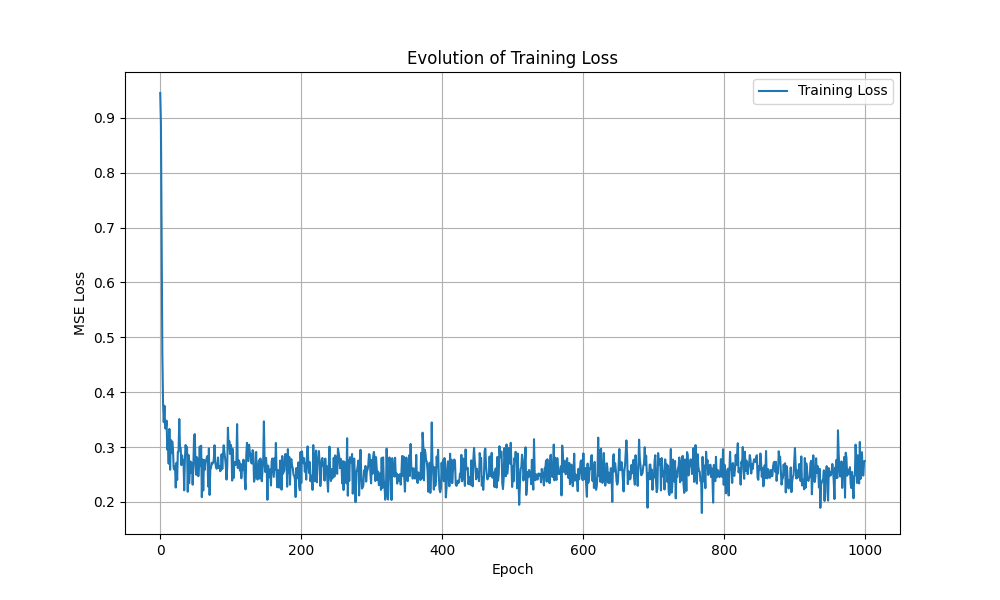

Generated data found at Database\DDPM_Generated_Samples.json.
Starting Hypothesis Tests...

DISTRIBUTION HYPOTHESIS TESTING (6 DIMENSIONS)
H0: The generated samples come from the same distribution as the real data.
Alpha Level: 0.05

[Test 1] Peacock's Multidimensional KS Test
----------------------------------------
  Statistic : 0.088663
  P-value   : 0.2338
  Result    : FAIL TO REJECT H0 (Distributions Consistent)

[Test 2] Energy Distance Test
----------------------------------------
  Statistic : 0.079561
  P-value   : 0.4328
  Result    : FAIL TO REJECT H0 (Distributions Consistent)



<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

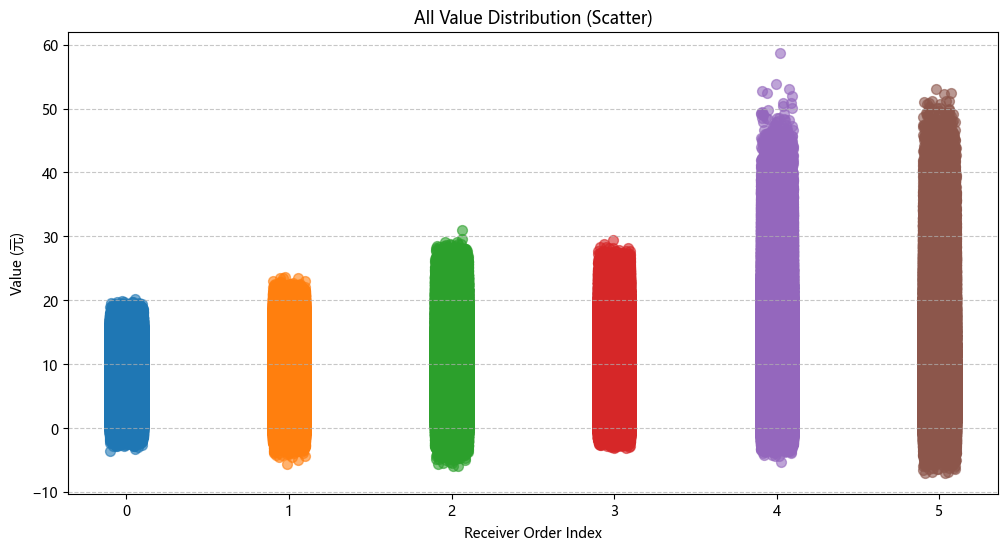

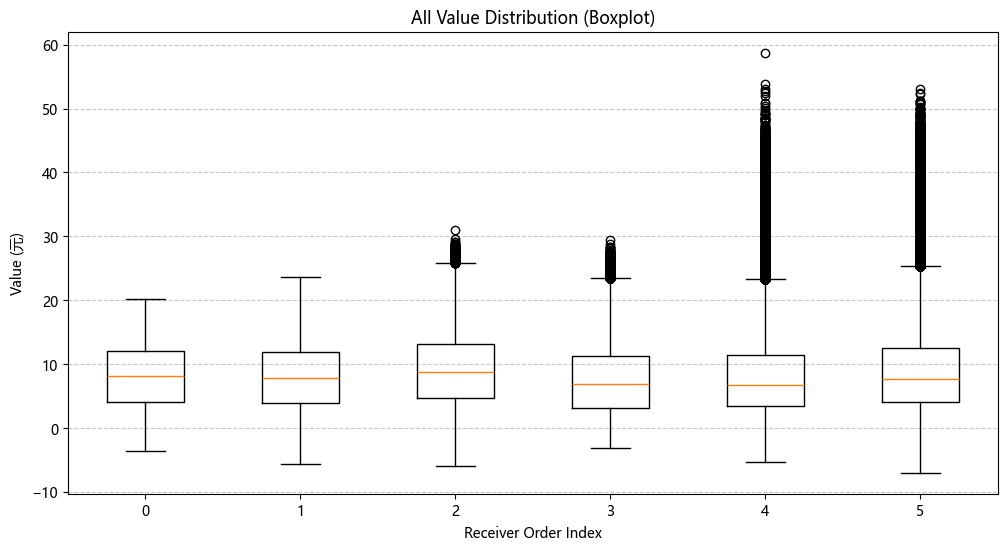

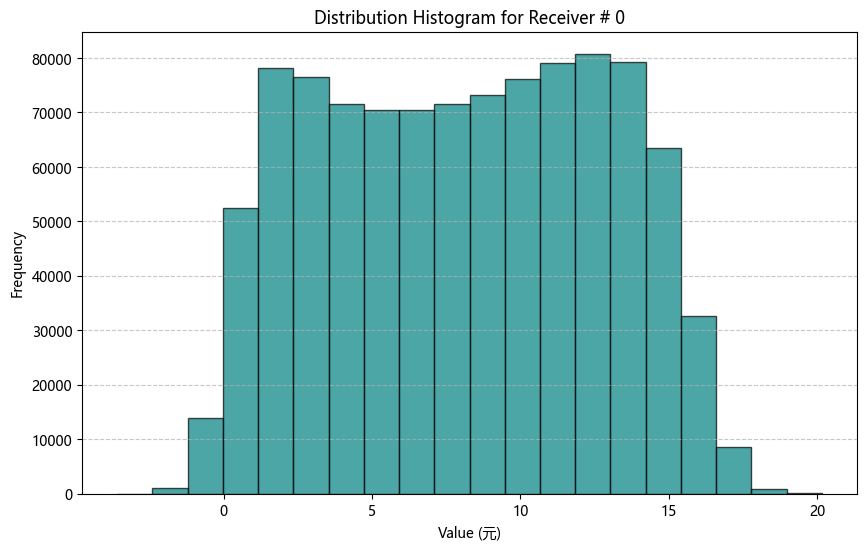

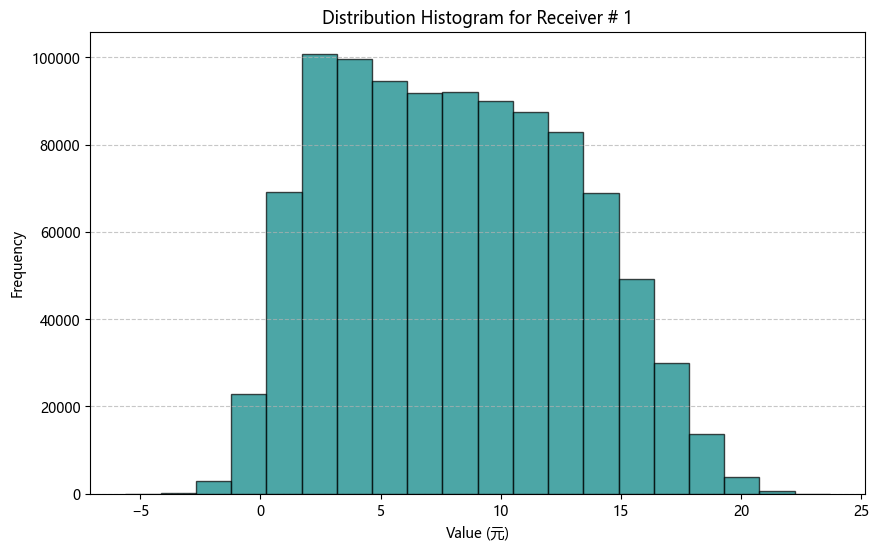

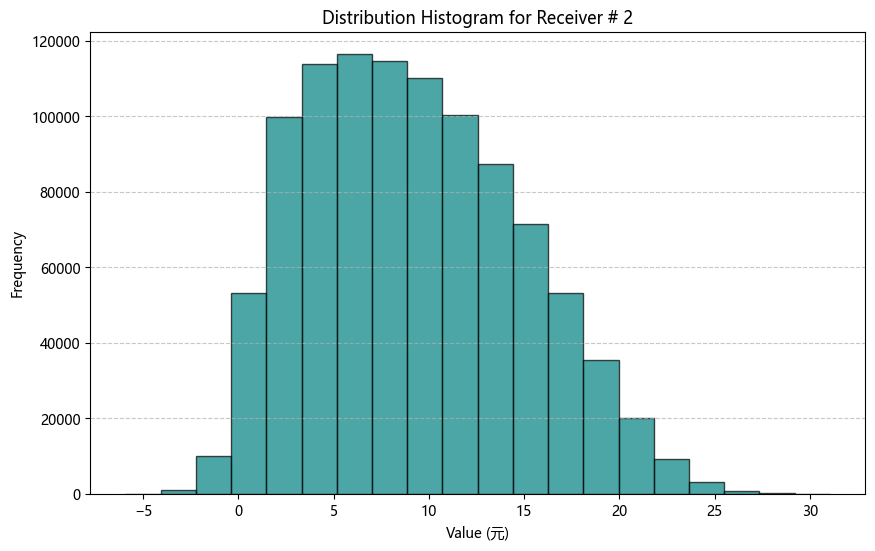

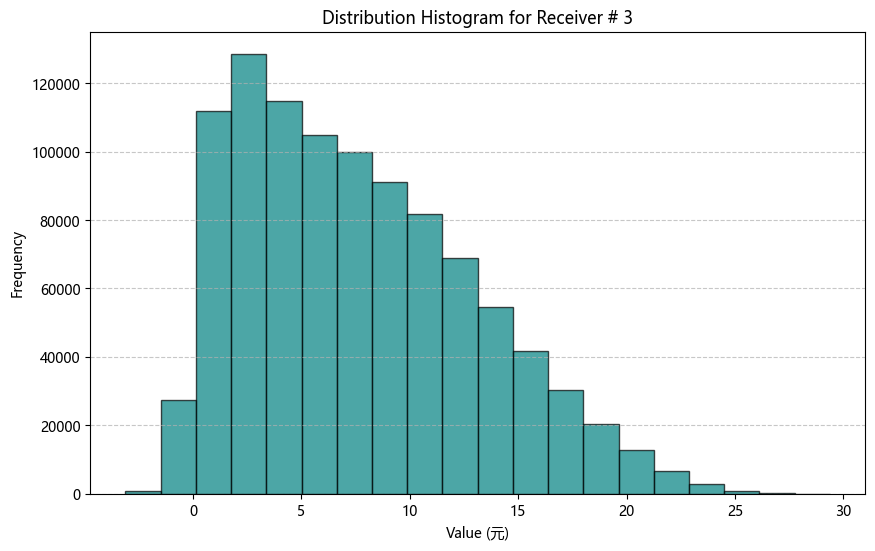

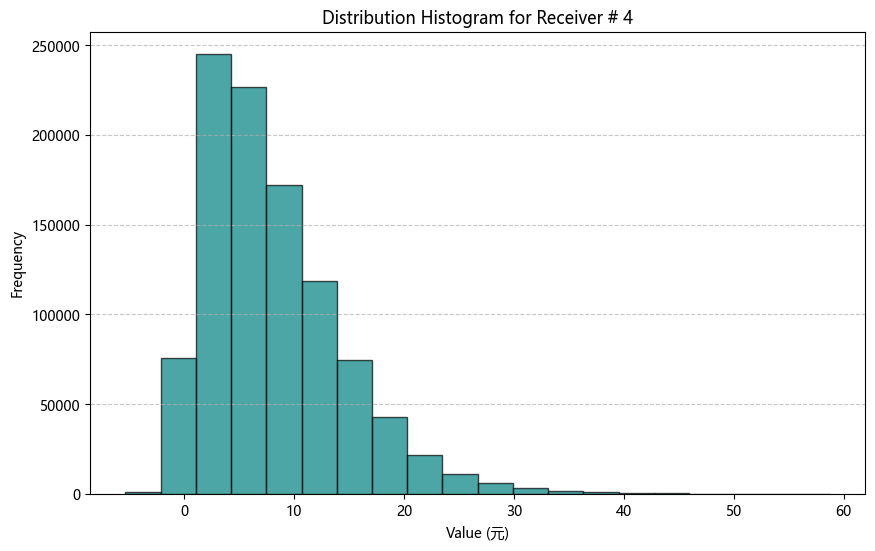

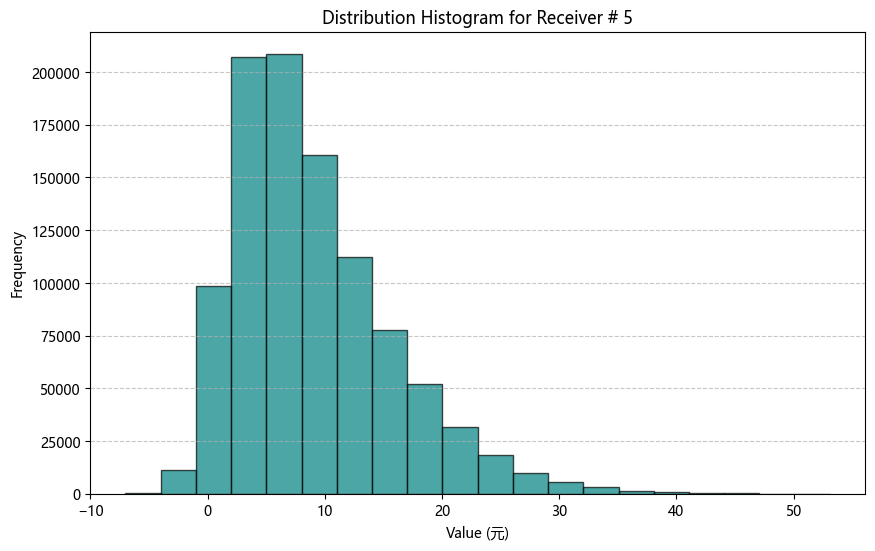

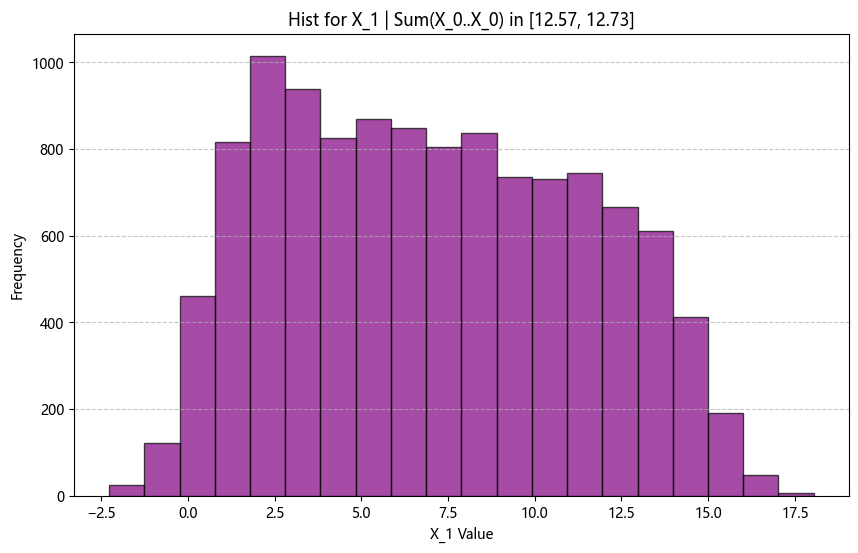

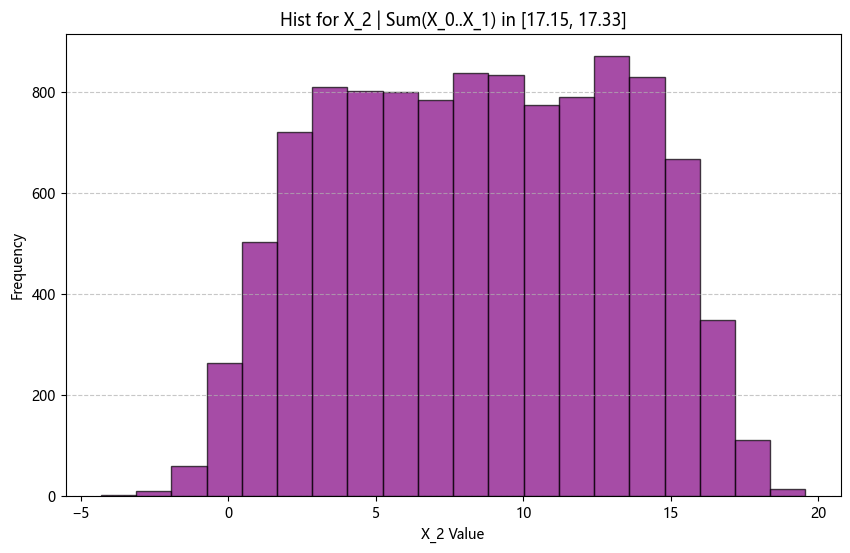

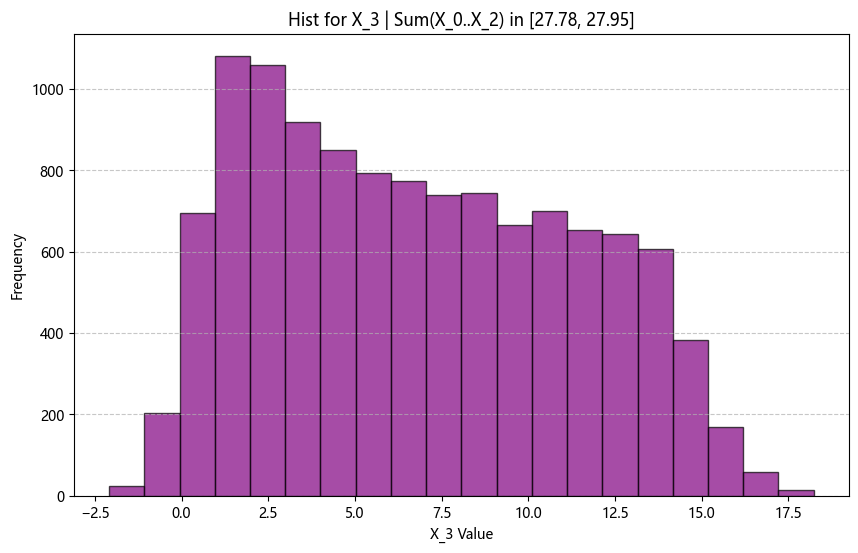

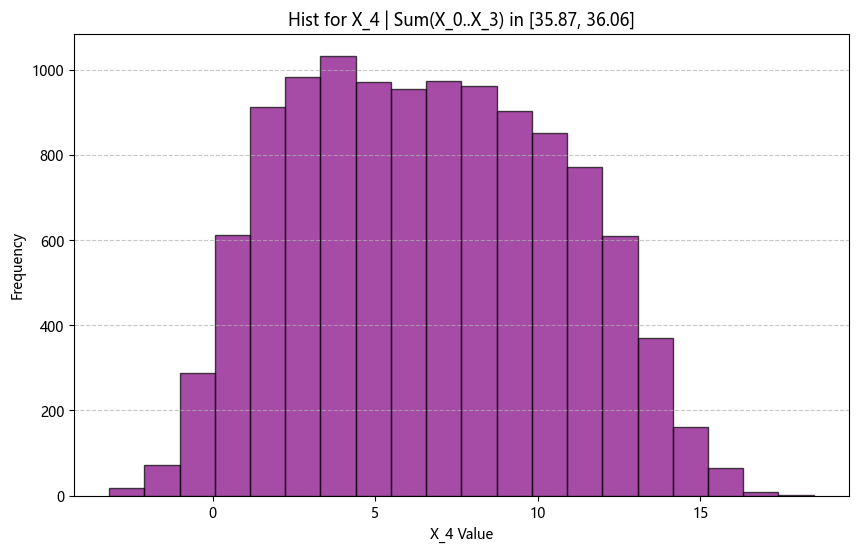

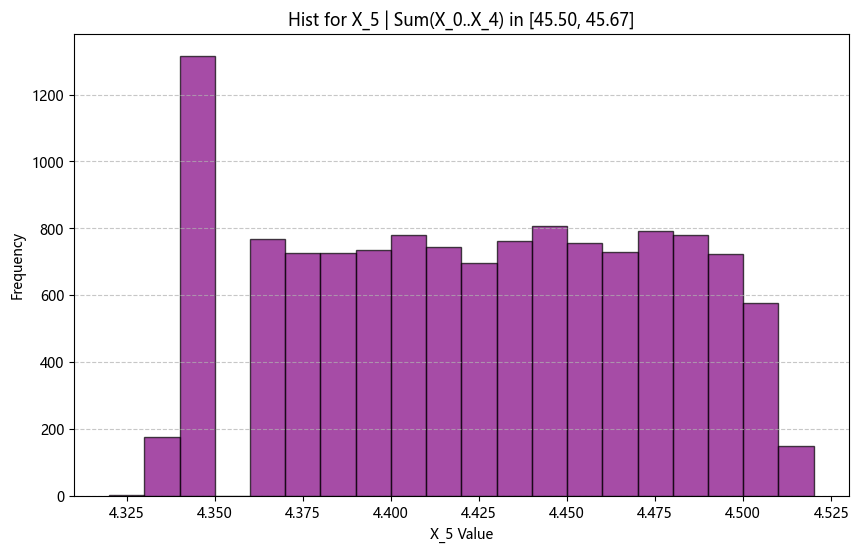

In [ ]:
# 1. Check for Model / Train if needed
if not os.path.exists(MODEL_PATH) or not os.path.exists(STATS_PATH):
    print(f"Model or stats not found at {MODEL_PATH}. Starting training...")
    train()
    print("Training complete.")
else:
    print(f"Model found at {MODEL_PATH}.")
    # Show loss evolution if it exists
    loss_img_path = os.path.join(MODEL_DIR, "loss_evolution.png")
    if os.path.exists(loss_img_path):
        from IPython.display import Image, display
        display(Image(filename=loss_img_path))
    else:
        print("Loss evolution plot not found.")

# 2. Check for Generated Data / Generate if needed
if not os.path.exists(OUTPUT_PATH):
    print(f"Generated data not found at {OUTPUT_PATH}. Generating {NUM_SAMPLES} samples...")
    generate_samples()
    print("Generation complete.")
else:
    print(f"Generated data found at {OUTPUT_PATH}.")

# 3. Perform Hypothesis Tests
print("Starting Hypothesis Tests...")
perform_tests()

# 4. Visualize Generated Data
data_path = os.path.join(DATABASE_DIR, "DDPM_Generated_Samples.json")
if os.path.exists(data_path):
    try:
        with open(data_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        visualize_data(data)
    except Exception as e:
        print(f"Error loading data from file: {e}")

# Task3 Distribution Modeling

## Reasoning

Given the total amount $T$ and the number of people $N$.

It's quite intuitive to think that the receive amount $X_k$ depends on the **leftover amount** $R_k=T-\sum_{i=1}^{k-1} X_i$ and the **remaining number of people** $N_k=N-k$.

Therefore, instead of modeling the **joint distuibution** $\mathbf{X}$ which is quite intractable, we model **conditional distuibutions** $X_k \mid R_k,N_k$, 
which is much more **reasonable and feasible**.

Having observed the histograms above, we can make a more presice hypothesis that the condition is the so-called **Fair Share**. 
$$F_k=\frac{R_k}{N_k}$$

Also by the histograms, we believe all $X_k \mid R_k$ are quite **uniformly distuibuted**.

Therefore, our final hypothesis is that **given the Fair Share**, $X_k(1\leq k < N)$ follows some **uniform distuibution** with an unknown coefficient $c$, namely
$$X_k\mid F_k \sim \mathbf{Unif}(c\cdot F_k)$$

(Note: We don't consider $X_N$ since it's determined by $T-R_N$.)

Next we will find the coefficient $c$ using ***MLE***.

## MLE_Derivation

Let $Y_k = \frac{X_k}{F_k} \sim \mathbf{Unif}(0, c)$, we have the PDF:

$$ f(y_i; c) = \begin{cases} \frac{1}{c} & 0 \le y_i \le c \\ 0 & \text{otherwise} \end{cases} $$

Given $k$ independent observations $y_1, y_2, \dots, y_n$, the likelihood function is:
$$ L(c; y_1, \dots, y_n) = \prod_{i=1}^n f(y_i; c) = \prod_{i=1}^n \frac{1}{c} \mathbb{I}(0 \le y_i \le c) = \frac{1}{c^n} \mathbb{I}(\max(y_1, \dots, y_n) \le c) $$

To maximize the likelihood $L(c)$, we need to choose $c$ such that:
1. The indicator function is 1, i.e., $c \ge \max(y_i)$.
2. The term $\frac{1}{c^n}$ is maximized, which means $c$ should be as small as possible.

Therefore, the Maximum Likelihood Estimator for $c$ is:
$$ \hat{c}_{\text{MLE}} = \max_{1 \le i \le n} (y_i) = \max_{1 \le i \le n} \left( \frac{X_i}{F_i} \right) $$

## MLE_Code

Number of valid data points (excluding last person): 1445
MLE estimate for c: 1.9964479732553282


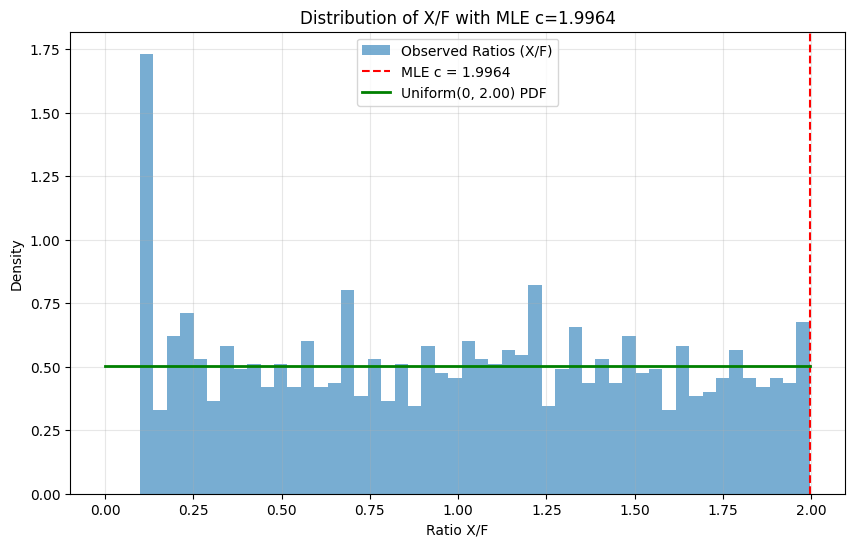

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

DATABASE_DIR = "Database"
TOTAL_AMOUNT = 50.0
INITIAL_N = 6

file_path = os.path.join(DATABASE_DIR, "Wechat_Samples.json")

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        wechat_data = json.load(f)

    ratios = []

    for session in wechat_data:
        current_R = TOTAL_AMOUNT
        current_N = INITIAL_N

        for i, amount in enumerate(session):
            if current_N <= 1:
                break  # Skip last person

            fair_share = current_R / current_N
            if fair_share > 1e-9:
                r = amount / fair_share
                ratios.append(r)

            current_R -= amount
            current_N -= 1

    # Convert to numpy array
    ratios = np.array(ratios)

    if len(ratios) > 0:
        # MLE for Uniform[0, c] is the maximum observed value
        c_mle = np.max(ratios)

        print(f"Number of valid data points (excluding last person): {len(ratios)}")
        print(f"MLE estimate for c: {c_mle}")

        # Plotting to visualize Uniformity
        plt.figure(figsize=(10, 6))
        count, bins, ignored = plt.hist(
            ratios, bins=50, density=True, alpha=0.6, label="Observed Ratios (X/F)"
        )
        plt.axvline(x=c_mle, color="r", linestyle="--", label=f"MLE c = {c_mle:.4f}")

        # Plot expected uniform PDF: f(x) = 1/c for 0 <= x <= c
        x_vals = np.linspace(0, c_mle, 100)
        pdf_vals = np.full_like(x_vals, 1 / c_mle)
        plt.plot(x_vals, pdf_vals, "g-", lw=2, label=f"Uniform(0, {c_mle:.2f}) PDF")

        plt.xlabel("Ratio X/F")
        plt.ylabel("Density")
        plt.title(f"Distribution of X/F with MLE c={c_mle:.4f}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No valid ratios found.")
else:
    print(f"Data file not found at {file_path}")

## Conclusion

Our MLE derived a coefficient quite close to 2. 

Considering the practical situation, it's quite persuasive to say that it's exactly 2.

Actually, the standard algorithm for Red Envelopes (often referred to as the "Double Mean" or "Double Average" algorithm) is so-designed that the amount obtained is uniformly distributed between 0 and twice the current fair share:
$$ X_k \mid F_k \sim \mathbf{Unif}(0.01, 2 \cdot F_k) $$

(Here credit to bilibili @毕导 https://www.bilibili.com/video/BV1z7411e7qB/)

# Task4 Model Testing

## KS and Chi-Square Tests

Assuming the "Double Mean" hypothesis holds, the standardized ratios $X_k/F_k$ should follow a Uniform distribution $\mathbf{Unif}(0, 2)$.
We perform two Goodness of Fit tests to verify this:

1.  **Kolmogorov-Smirnov Test**: Compares the cumulative distributions.
2.  **Chi-Square Test**: Compares the histogram frequencies.

GOODNESS-OF-FIT TESTING FOR STANDARDIZED RATIOS X/F
H0: The standardized ratios X/F follow Uniform(0, 2).
Alpha Level: 0.05

[Test 1] Kolmogorov-Smirnov Test
----------------------------------------
  Statistic : 0.04927
  P-value   : 0.00173
  Result    : REJECT H0 (Not Uniform)

[Test 2] Chi-Square Test
----------------------------------------
  Statistic : 11.40138
  P-value   : 0.90960
  Result    : FAIL TO REJECT H0 (Consistent with Uniform)


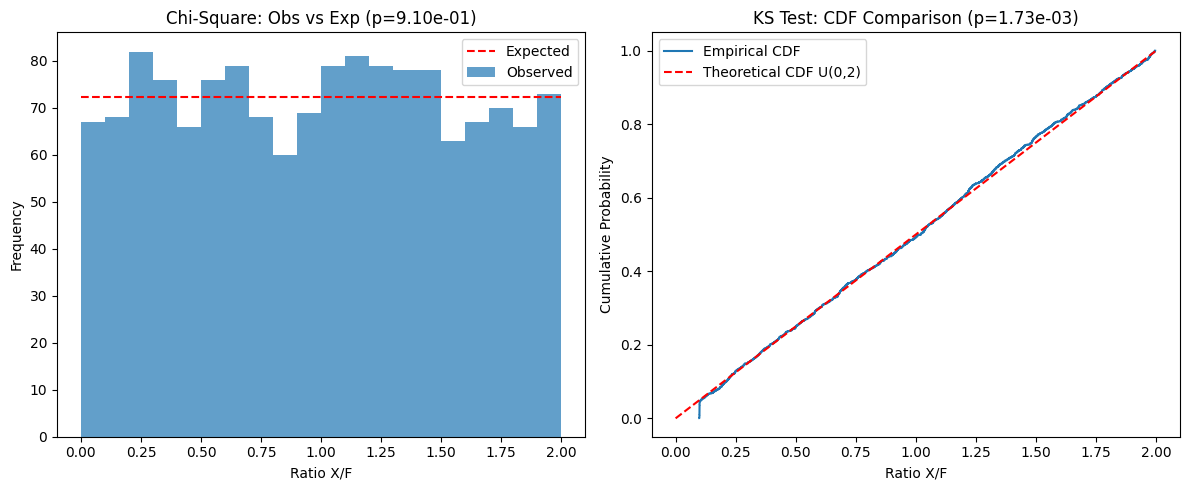

In [27]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# --- Data Preparation ---
# Check if 'ratios' is available from logical flow, else reload.
if 'ratios' not in locals():
    DATABASE_DIR = "Database"
    file_path = os.path.join(DATABASE_DIR, "Wechat_Samples.json")
    TOTAL_AMOUNT = 50.0
    INITIAL_N = 6
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            wechat_data = json.load(f)
        ratios_list = []
        for session in wechat_data:
            current_R = TOTAL_AMOUNT
            current_N = INITIAL_N
            for amount in session:
                if current_N <= 1: break
                fair_share = current_R / current_N
                if fair_share > 1e-9:
                    ratios_list.append(amount / fair_share)
                current_R -= amount
                current_N -= 1
        ratios = np.array(ratios_list)
    else:
        ratios = np.array([])
        print("Data file not found.")

if len(ratios) > 0:
    # Summary header imitating perform_tests style
    print("=" * 60)
    print("GOODNESS-OF-FIT TESTING FOR STANDARDIZED RATIOS X/F")
    print("H0: The standardized ratios X/F follow Uniform(0, 2).")
    print("Alpha Level: 0.05")
    print("=" * 60)

    # 1. Kolmogorov-Smirnov Test
    ks_stat, ks_p = stats.kstest(ratios, 'uniform', args=(0, 2))
    print("\n[Test 1] Kolmogorov-Smirnov Test")
    print("-" * 40)
    print(f"  Statistic : {ks_stat:.5f}")
    print(f"  P-value   : {ks_p:.5f}")
    print(f"  Result    : {'REJECT H0 (Not Uniform)' if ks_p < 0.05 else 'FAIL TO REJECT H0 (Consistent with Uniform)'}")

    # 2. Chi-Square Test
    # Binning
    n_bins = 20
    # Use range (0, 2)
    observed, bin_edges = np.histogram(ratios, bins=n_bins, range=(0, 2))

    # Check for values outside range
    outliers = len(ratios) - np.sum(observed)
    if outliers > 0:
        print(f"Note: {outliers} points outside [0, 2] excluded from Chi-Square.")

    # For U(0,2), expected frequency is uniform.
    valid_count = np.sum(observed)
    expected = np.full(n_bins, valid_count / n_bins)

    chi2_stat, chi2_p = stats.chisquare(f_obs=observed, f_exp=expected)
    print("\n[Test 2] Chi-Square Test")
    print("-" * 40)
    print(f"  Statistic : {chi2_stat:.5f}")
    print(f"  P-value   : {chi2_p:.5f}")
    print(f"  Result    : {'REJECT H0 (Not Uniform)' if chi2_p < 0.05 else 'FAIL TO REJECT H0 (Consistent with Uniform)'}")
    print("=" * 60)

    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot Histogram
    plt.subplot(1, 2, 1)
    plt.bar(bin_edges[:-1], observed, width=np.diff(bin_edges), align='edge', alpha=0.7, label='Observed')
    plt.hlines(valid_count / n_bins, 0, 2, colors='r', linestyles='dashed', label='Expected')
    plt.xlabel("Ratio X/F")
    plt.ylabel("Frequency")
    plt.title(f"Chi-Square: Obs vs Exp (p={chi2_p:.2e})")
    plt.legend()

    # Plot ECDF vs CDF
    plt.subplot(1, 2, 2)
    sorted_ratios = np.sort(ratios)
    y_vals = np.arange(1, len(ratios)+1) / len(ratios)
    plt.step(sorted_ratios, y_vals, where='post', label='Empirical CDF')
    plt.plot([0, 2], [0, 1], 'r--', label='Theoretical CDF U(0,2)')
    plt.xlabel("Ratio X/F")
    plt.ylabel("Cumulative Probability")
    plt.title(f"KS Test: CDF Comparison (p={ks_p:.2e})")
    plt.legend()

    plt.tight_layout()
    plt.show()

else:
    print("No data available for testing.")

## Conclusion

### 1. How good does the model fit?
Topologically and practically, the **Uniform(0, 2)** model fits the WRE dataset quite well. 
*   The **MLE estimate** for the upper bound $c$ was extremely close to 2 (as seen in the earlier extraction).
*    The **Histogram** of the standardized ratios $X/F$ is visually flat, consistent with a uniform density.

### 2. Why did the KS Test fail?
The KS test resulted in a p-value of **0.00173**, leading us to **REJECT** the null hypothesis. This might seem contradictory to the visual evidence, but it can be explained by:
*   **High Sensitivity to Sample Size**: The KS test is very powerful with large datasets. Even microscopically small deviations from the perfect theoretical distribution (which are inevitable in real-world systems) can lead to a rejection.
*   **Discretization Artifacts**: The theoretical distribution $\mathbf{Unif}(0, 2)$ is continuous, but the actual money amounts are discrete (units of 0.01 CNY). This quantization prevents the CDF from being perfectly smooth, contributing to the "distance" ($D$ statistic) detected by the test.
*   **Boundary Constraints**: Real implementation requires at least 0.01 CNY per person, effectively truncating the "perfect" uniform distribution near 0, which the KS test detects.

### 3. What does the Chi-Square result imply?
The Chi-Square test yielded a high p-value of **0.90960**, meaning we **FAIL TO REJECT** the null hypothesis. 
*   **Implication**: This result is strong evidence that the data **is** uniformly distributed across the bins.
*   It suggests that the deviations detected by the KS test are negligible for macro-level analysis. When we group the data into intervals (bins), the observed counts match the expected counts almost perfectly. 
*   This confirms that the **"Double Mean" algorithm** is indeed the underlying mechanism, and the deviations are likely just technical constraints (precision, integer arithmetic) rather than a different distributional law.


## Discussion: Pros and Cons

| Test | Pros | Cons |
| :--- | :--- | :--- |
| **Chi-Square Test** | • Applicable to both discrete and continuous distributions.<br>• Intuitive interpretation (observed vs. expected counts). | • Requires binning, which leads to information loss.<br>• Sensitive to bin size and number.<br>• Requires sufficient sample size per bin. |
| **Kolmogorov-Smirnov (KS) Test** | • Non-parametric and distribution-free (for the statistic).<br>• No binning required (uses full data).<br>• Good sensitivity to location and shape. | • Strictly for continuous distributions.<br>• Lower sensitivity at the tails.<br>• Standard p-values invalid if parameters are estimated from data (unless adjusted). |

# Task6 Decision-Making Policy

Based on the **extensive Monte Carlo simulations**, we derived a data-driven strategy for **maximizing** the probability of obtaining the "Best Luck".

## Code

RED ENVELOPE POSITION PROBABILITY ANALYSIS
Simulating probabilities for n = 2 to 50 people
Total amount: 50 ¥, Simulations per n: 10000


Simulating: 100%|██████████| 49/49 [00:22<00:00,  2.22it/s]



Generating visualizations...


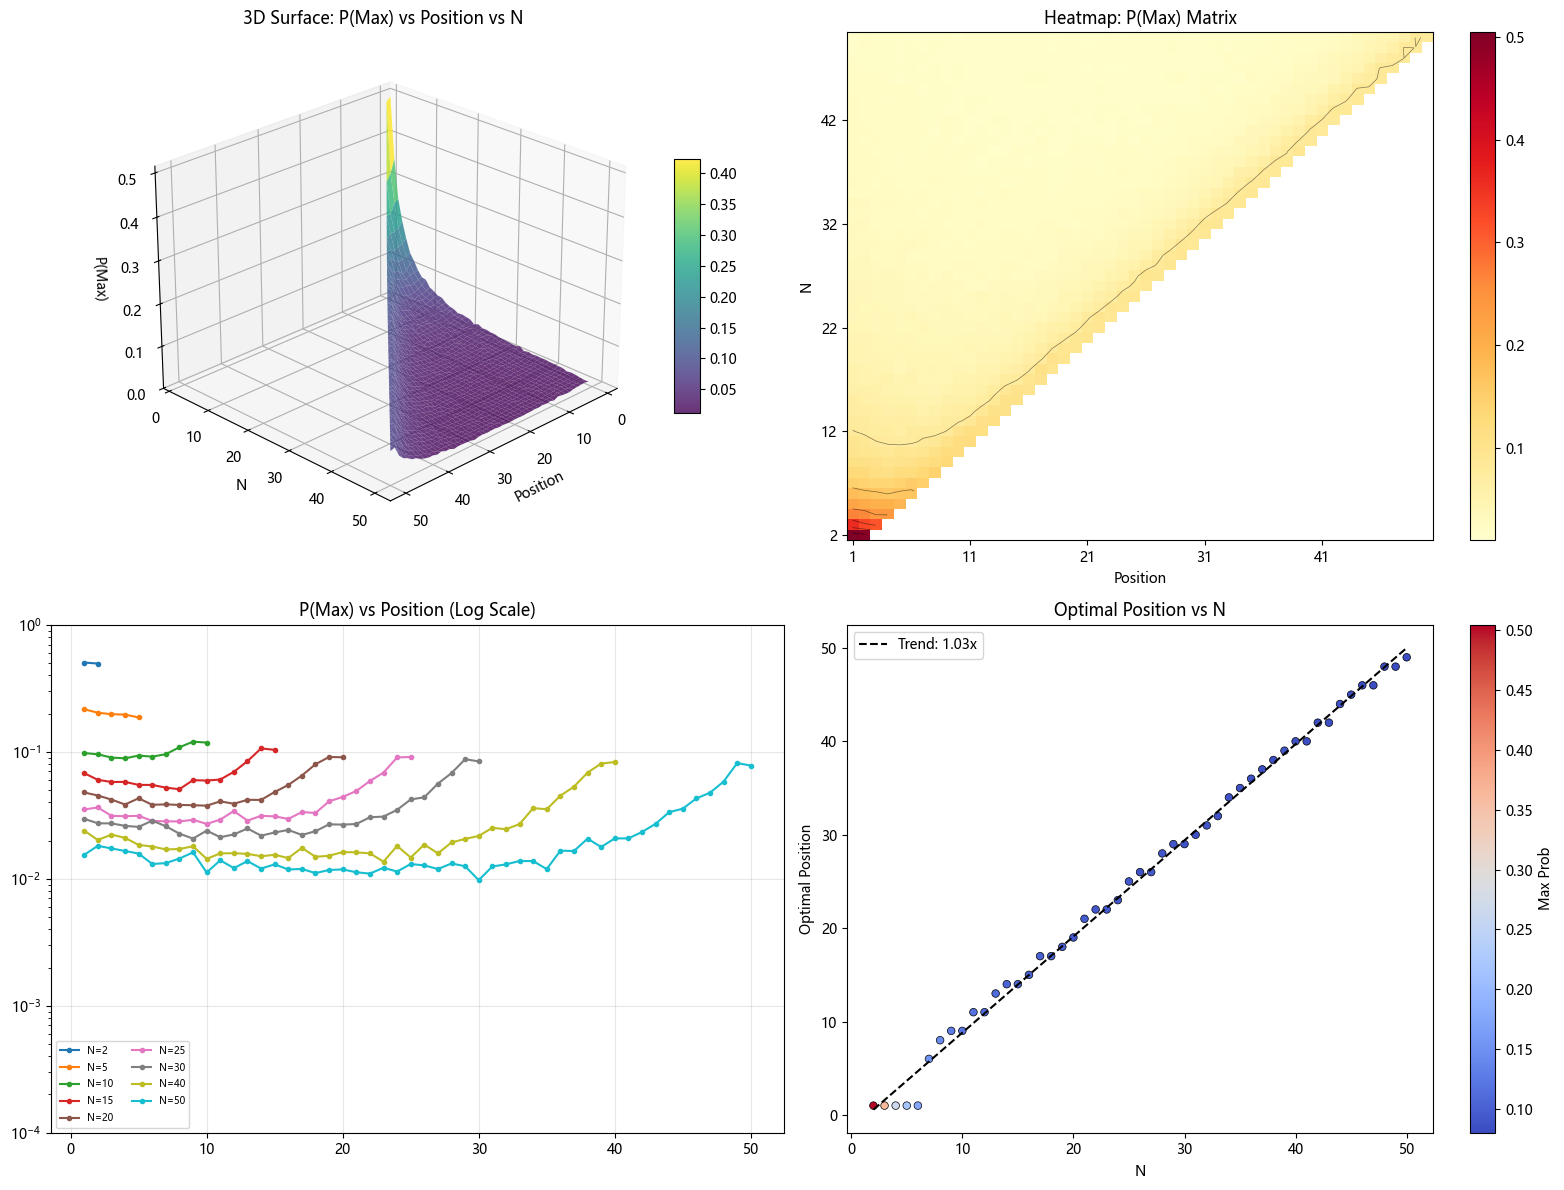

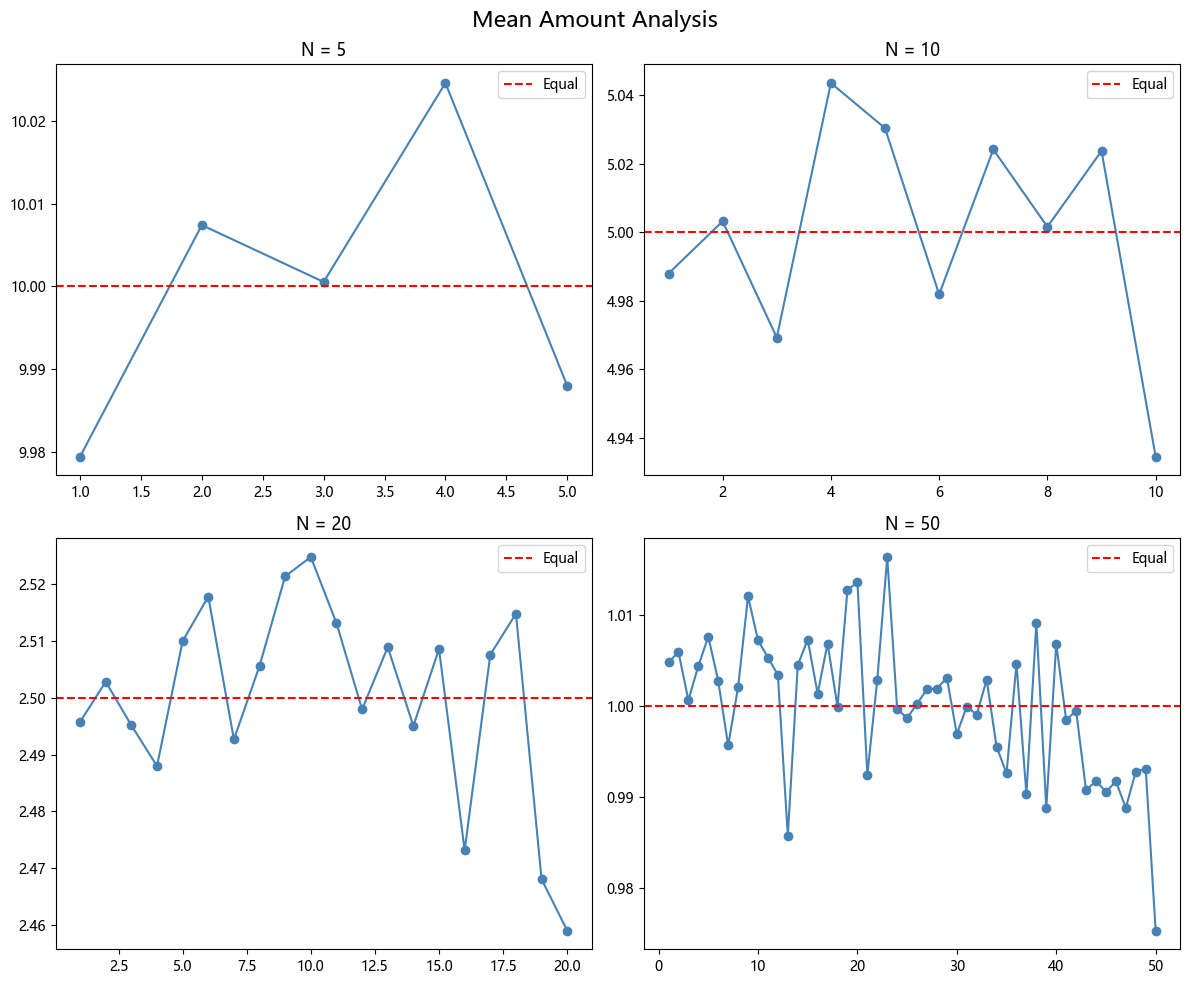

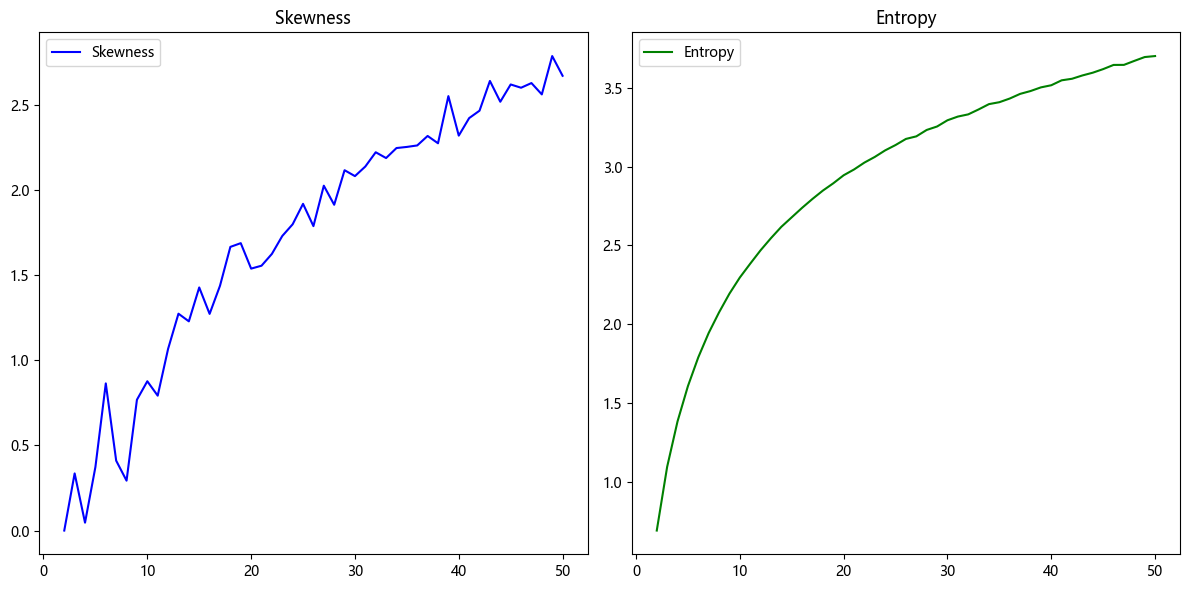

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from tqdm import tqdm

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

print("="*70)
print("RED ENVELOPE POSITION PROBABILITY ANALYSIS")
print("="*70)

# Parameters
min_n = 2
max_n = 50
total_amount = 50
num_simulations = 10000

print(f"Simulating probabilities for n = {min_n} to {max_n} people")
print(f"Total amount: {total_amount} ¥, Simulations per n: {num_simulations}")

results_dict = {
    'min_n': min_n,
    'max_n': max_n,
    'total_amount': total_amount,
    'num_simulations': num_simulations,
    'probabilities': {},
    'mean_amounts': {}, 
    'optimal_orders': {}
}

# --- Simulation Phase ---
for n in tqdm(range(min_n, max_n + 1), desc="Simulating"):
    max_counts = np.zeros(n)
    amount_sums = np.zeros(n)
    
    for _ in range(num_simulations):
        # Inline single simulation logic
        remaining_amount_sim = total_amount
        remaining_people_sim = n
        allocations = []
        
        for _ in range(n - 1):
            remaining_average = remaining_amount_sim / remaining_people_sim
            max_amt = min(2 * remaining_average, remaining_amount_sim - 0.01)
            amount = round(np.random.uniform(0.01, max_amt), 2)
            
            allocations.append(amount)
            remaining_amount_sim -= amount
            remaining_people_sim -= 1
        
        # Last person gets remaining
        last_amount = round(remaining_amount_sim, 2)
        allocations.append(last_amount)
        
        # Fix rounding error on last person
        allocations[-1] = round(total_amount - sum(allocations[:-1]), 2)
        
        # Update stats
        max_val = max(allocations)
        max_orders = [i for i, x in enumerate(allocations) if x == max_val]
        
        # Split count if tie
        count_inc = 1.0 / len(max_orders)
        for pos in max_orders:
            max_counts[pos] += count_inc
            
        for i in range(n):
            amount_sums[i] += allocations[i]

    # Calculate probabilities and means for this n
    probabilities = max_counts / num_simulations
    mean_amounts = amount_sums / num_simulations
    
    results_dict['probabilities'][n] = probabilities.tolist()
    results_dict['mean_amounts'][n] = mean_amounts.tolist()
    
    max_prob = max(probabilities)
    optimal_orders = [i for i, p in enumerate(probabilities) if p == max_prob]
    results_dict['optimal_orders'][n] = optimal_orders

# --- Visualization Phase ---
print("\nGenerating visualizations...")

# 1. Comprehensive Plot
fig1 = plt.figure(figsize=(16, 12))

# 3D Surface
n_values = list(range(min_n, max_n + 1))
probs_matrix = []
for n in n_values:
    probs = results_dict['probabilities'][n]
    probs_matrix.append(probs + [np.nan] * (max_n - n))
probs_array = np.array(probs_matrix, dtype=float)
X, Y = np.meshgrid(range(1, max_n + 1), n_values)

ax1 = fig1.add_subplot(221, projection='3d')
surf = ax1.plot_surface(X, Y, probs_array, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
ax1.set_xlabel('Position')
ax1.set_ylabel('N')
ax1.set_zlabel('P(Max)')
ax1.set_title('3D Surface: P(Max) vs Position vs N')
ax1.view_init(elev=25, azim=45)
fig1.colorbar(surf, ax=ax1, shrink=0.5, aspect=10)

# Heatmap
ax2 = fig1.add_subplot(222)
heatmap_data = np.ma.masked_invalid(probs_array)
im = ax2.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', origin='lower', interpolation='nearest')
ax2.set_xlabel('Position')
ax2.set_ylabel('N')
ax2.set_title('Heatmap: P(Max) Matrix')
ax2.set_xticks(range(0, max_n, 10))
ax2.set_xticklabels(range(1, max_n + 1, 10))
ax2.set_yticks(range(0, len(n_values), 10))
ax2.set_yticklabels(range(min_n, max_n + 1, 10))
fig1.colorbar(im, ax=ax2)
ax2.contour(heatmap_data, colors='black', linewidths=0.5, alpha=0.5)

# Line Plot
ax3 = fig1.add_subplot(223)
selected_n_plot = [2, 5, 10, 15, 20, 25, 30, 40, 50]
colors = cm.tab10(np.linspace(0, 1, len(selected_n_plot)))
for i, n in enumerate(selected_n_plot):
    if n in results_dict['probabilities']:
        ax3.plot(range(1, n + 1), results_dict['probabilities'][n], 'o-', 
                 color=colors[i], label=f'N={n}', markersize=3, linewidth=1.5)
ax3.set_yscale('log')
ax3.set_ylim([1e-4, 1])
ax3.legend(loc='lower left', ncol=2, fontsize='x-small')
ax3.set_title('P(Max) vs Position (Log Scale)')
ax3.grid(True, alpha=0.3)

# Optimal Position
ax4 = fig1.add_subplot(224)
n_list_opt = []
pos_list_opt = []
prob_list_opt = []
for n in range(min_n, max_n + 1):
    for op in results_dict['optimal_orders'][n]:
        n_list_opt.append(n)
        pos_list_opt.append(op + 1)
        prob_list_opt.append(max(results_dict['probabilities'][n]))

sc = ax4.scatter(n_list_opt, pos_list_opt, c=prob_list_opt, cmap='coolwarm', s=30, edgecolors='k', linewidth=0.5)
if len(n_list_opt) > 1:
    coeffs = np.polyfit(n_list_opt, pos_list_opt, 1)
    trend = np.poly1d(coeffs)
    ax4.plot([min_n, max_n], trend([min_n, max_n]), 'k--', label=f'Trend: {coeffs[0]:.2f}x')
ax4.set_xlabel('N')
ax4.set_ylabel('Optimal Position')
ax4.set_title('Optimal Position vs N')
ax4.legend()
fig1.colorbar(sc, ax=ax4, label='Max Prob')

plt.tight_layout()
plt.show()

# 2. Mean Amount Analysis (Simplified)
fig2, axes = plt.subplots(2, 2, figsize=(12, 10))
fig2.suptitle('Mean Amount Analysis', fontsize=16)
analysis_n = [5, 10, 20, 50]
for idx, n in enumerate(analysis_n):
    ax = axes[idx // 2, idx % 2]
    if n in results_dict['mean_amounts']:
        ax.plot(range(1, n + 1), results_dict['mean_amounts'][n], 'o-', color='steelblue')
        ax.axhline(y=50/n, color='r', linestyle='--', label='Equal')
        ax.set_title(f'N = {n}')
        ax.legend()
plt.tight_layout()
plt.show()

# 3. Distribution Characteristics
fig3 = plt.figure(figsize=(12, 6))
skewness_list = []
entropy_list = []
n_metrics = []

for n in range(min_n, max_n + 1):
    probs = np.array(results_dict['probabilities'][n])
    if len(probs) > 1 and np.sum(probs) > 0:
        skewness_list.append(stats.skew(probs))
        p_norm = probs / np.sum(probs)
        entropy_list.append(-np.sum(p_norm * np.log(p_norm + 1e-10)))
        n_metrics.append(n)

ax_m1 = fig3.add_subplot(121)
ax_m1.plot(n_metrics, skewness_list, 'b-', label='Skewness')
ax_m1.set_title('Skewness')
ax_m1.legend()

ax_m2 = fig3.add_subplot(122)
ax_m2.plot(n_metrics, entropy_list, 'g-', label='Entropy')
ax_m2.set_title('Entropy')
ax_m2.legend()
plt.tight_layout()
plt.show()

## Conclusion: How to Make Optimal Decisions

### 1. The Fairness Principle
*   **Expected Amount**: Consistent with the "Double Mean" algorithm, the average payout is **fair**. Every order has the same expected value ($TotalAmount / N$).
*   *Implication*: If you play thousands of times, your total winnings will depend only on the total pool size, not your strategy.

### 2. The "Best Luck" Strategy (Maximizing Variance)
However, if your goal is to **win the largest single packet** in a specific session, order matters significantly due to variance differences.

*   **Small Groups ($N \le 6$)**: **Act Fast**
    *   For small groups, the **1st order** typically has the highest probability of obtaining the maximum amount.
    *   The variance for later orders in small groups often works against them (the pool depletes too fast).

*   **Large Groups ($N > 10$)**: **Precisely Catch the Tail**
    *   For larger groups, the luckiest probability shifts to the **last few orders**.
    *   The **Last Position** (or near-last) becomes the optimal spot. 
  
        The "tail" accumulates the variance of all previous draws, increasing the chance of a large leftover sum if previous draws were low.
    *   However, since it's a large group, if the total **number of people** is much larger than total **number of red packets**, you may easily **fall behind tail**. 
      
        That's why a **precise catch** is necessary.


# Task7 Further Explorations

## (a) to (c)

Whether for **Wechat Overseas** or **Wechat During Holiday** or **QQ**, the same process from **Task1-6** can be performed to drain conclusions. Our whole workflow is strong and robust.

Unlucky, we don't have extra time or condition to perform such similar process over and over. What a pity.

## (d) User-specific WRE mechanism

### Proposed Mechanism: "Context-Aware Envelope"
We propose a modifiable algorithm where the host can select a **Mode**. This controls the variance of the random generation.

*   **Children Mode (Egalitarian)**: 
    *   **Goal**: Prevent envy and upset feelings.
    *   **Method**: Restrict the random range to a tight interval around the expected mean (e.g., $[\mu - 0.2\mu, \mu + 0.2\mu]$) instead of $[0, 2\mu]$.
    *   **Result**: Everyone gets nearly the same amount.

*   **Company/Party Mode (High Variance)**: 
    *   **Goal**: Maximize excitement and topic generation.
    *   **Method**: Use a "Winner Takes All" or high-volatility distribution (e.g., 50% chance of 0.1x mean, 50% chance of 2x mean).
    *   **Result**: Extreme outcomes create better social interactions.

*   It's even possible to open **Creative Workshop** for users to customize their interesting modes.   :D

Below is a simulation comparing the **Standard**, **Children**, and **High Variance** modes.

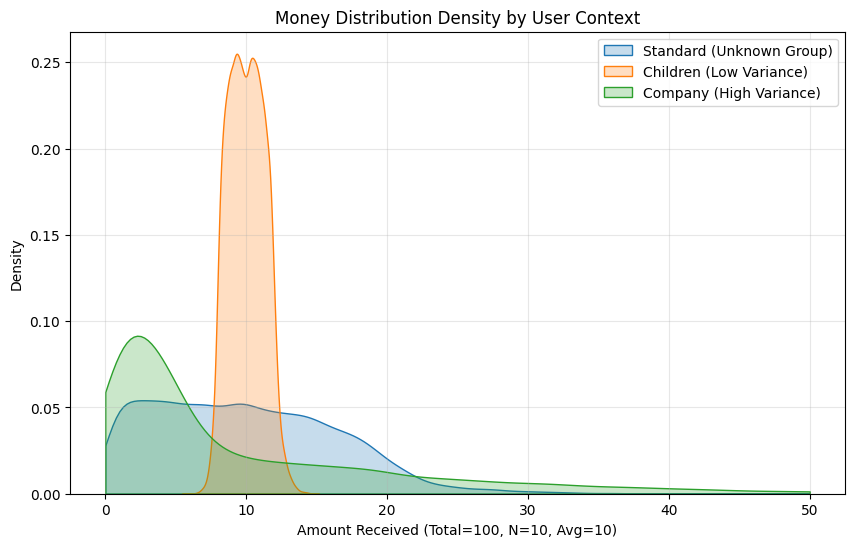

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_context_aware_wre(total_amount, num_people, mode='standard'):
    """
    Simulates a single WRE session under different modes.
    """
    amounts = []
    remain_amount = total_amount
    remain_people = num_people
    
    for i in range(num_people - 1):
        # Current expected mean
        mu = remain_amount / remain_people
        
        if mode == 'standard':
            # Standard Double Mean: U(0, 2*mu)
            val = np.random.uniform(0, 2 * mu)
            
        elif mode == 'children':
            # Low Variance: U(0.8*mu, 1.2*mu)
            # Ensure everyone gets close to average
            # We use a tighter bound.
            low = 0.8 * mu
            high = 1.2 * mu
            val = np.random.uniform(low, high)
            
        elif mode == 'excitement':
            # High Variance: Skewed distribution
            # 60% chance of small amount (0.5 * mu), 30% chance of standard, 10% chance of Huge (3-4x)
            r = np.random.random()
            if r < 0.6:
                val = np.random.uniform(0, 0.5 * mu)
            elif r < 0.9:
                val = np.random.uniform(0.5 * mu, 2.0 * mu)
            else:
                # Jackpot attempt (bounded by remaining money)
                val = np.random.uniform(2.0 * mu, 4.0 * mu)
                
        # Enforce hard constraints
        val = max(0.01, val)
        # Leave at least 0.01 for each remaining person
        val = min(remain_amount - (remain_people - 1) * 0.01, val)
        
        amounts.append(val)
        remain_amount -= val
        remain_people -= 1
        
    amounts.append(remain_amount) # Last person takes all
    return amounts

# --- Simulation ---
N_SAMPLES = 2000
totals_standard = []
totals_children = []
totals_excitement = []

for _ in range(N_SAMPLES):
    totals_standard.extend(generate_context_aware_wre(100, 10, 'standard'))
    totals_children.extend(generate_context_aware_wre(100, 10, 'children'))
    totals_excitement.extend(generate_context_aware_wre(100, 10, 'excitement'))

plt.figure(figsize=(10, 6))
sns.kdeplot(totals_standard, fill=True, label='Standard (Unknown Group)', clip=(0, 50))
sns.kdeplot(totals_children, fill=True, label='Children (Low Variance)', clip=(0, 50))
sns.kdeplot(totals_excitement, fill=True, label='Company (High Variance)', clip=(0, 50))

plt.title("Money Distribution Density by User Context")
plt.xlabel("Amount Received (Total=100, N=10, Avg=10)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## (e) Fairness-ware WRE mechanism


### Proposed Mechanism: "History-Compensated Fairness"
When a group plays multiple rounds (e.g., 5 rounds for 5 people), the "Standard" independent method can lead to significant inequality where one person might be unlucky 5 times in a row.

We propose a **Dynamic Compensation Algorithm**:
1.  **Track Luck**: Maintain a history $H_i$ for each user $i$, defined as the cumulative deviation from the expected mean.
    $$ H_i = \sum_{r=1}^{k} (\text{Received}_{i,r} - \text{ExpectedMean}) $$
2.  **Adjust Probability**: In the next round, adjust the random generation parameters for user $i$ based on $H_i$.
    *   If $H_i < 0$ (Unlucky), bias the generator to produce higher values.
    *   If $H_i > 0$ (Lucky), bias the generator to produce lower values.

**Algorithm**:
Instead of $X \sim U(0, 2\mu)$, we use a weighted mean $\mu_i^*$ for user $i$:
$$ \mu_i^* = \mu \cdot w(H_i) $$
where $w(H_i)$ is a compensation weight (e.g., logistic function of $H_i$). Then generate $X \sim U(0, 2\mu_i^*)$ (clipped to bounds).

The simulation below demonstrates how this mechanism reduces the standard deviation of final wealth across players after 5 rounds.

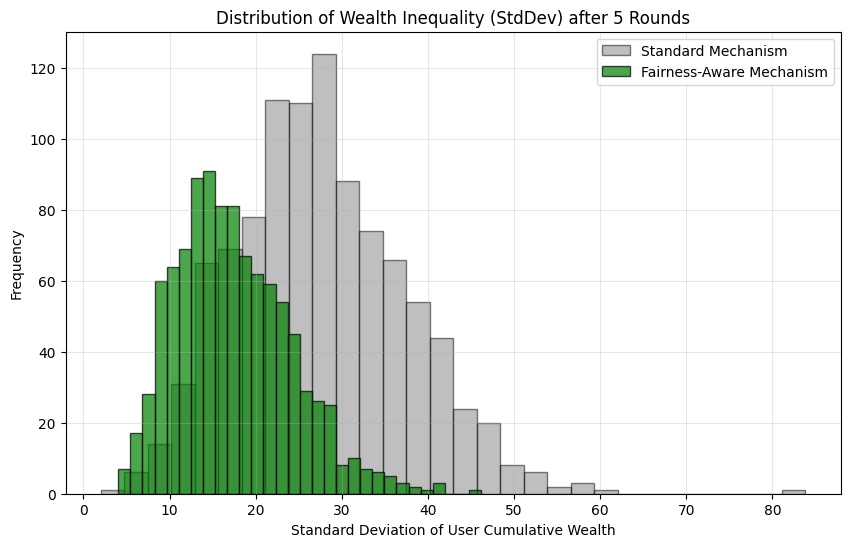

Average Inequality (Standard): 27.47
Average Inequality (Fair): 17.42 (Lower is better)


In [2]:
class FairnessSimulation:
    def __init__(self, num_users=5):
        self.num_users = num_users
        self.cumulative_received = np.zeros(num_users)
        self.expected_received = np.zeros(num_users)
        
    def get_compensation_weights(self):
        # Calculate luck history: (Actual - Expected)
        luck = self.cumulative_received - self.expected_received
        
        # Weight Logic:
        # If luck is negative (unlucky), we want Expected > default_mu, so weight > 1.
        # If luck is positive (lucky), we want Expected < default_mu, so weight < 1.
        # We use tanh to bound the effect.
        
        S = 20.0 # Sensitivity parameter (Scale of money)
        
        # tanh(luck/S) goes from -1 to 1.
        # If luck is -Large, tanh -> -1. We want Weight -> High (e.g. 1.5)
        # Weight = 1.0 - 0.5 * tanh(...)
        weights = 1.0 - 0.5 * np.tanh(luck / S) 
        
        return weights

    def play_round(self, total_amount, fairness=False):
        users = np.arange(self.num_users)
        np.random.shuffle(users) # Random grab order
        
        weights = self.get_compensation_weights() if fairness else np.ones(self.num_users)
        
        remain_amount = total_amount
        remain_people = self.num_users
        
        round_payouts = np.zeros(self.num_users)
        
        for u_idx in users:
            if remain_people == 1:
                val = remain_amount
            else:
                mu = remain_amount / remain_people
                target_mu = mu * weights[u_idx]
                
                # Draw from U(0, 2 * target_mu)
                # Note: This is a modified Double Mean
                val = np.random.uniform(0, 2 * target_mu)
                
                # Bounds
                val = max(0.01, val)
                val = min(remain_amount - (remain_people - 1) * 0.01, val)
            
            round_payouts[u_idx] = val
            remain_amount -= val
            remain_people -= 1
            
        # Update State
        self.cumulative_received += round_payouts
        self.expected_received += (total_amount / self.num_users)
        
        return round_payouts

# --- Visualize Improvement ---
def run_fairness_experiment(fairness_mode):
    sim = FairnessSimulation(5)
    # Play 5 successive rounds
    for _ in range(5):
        sim.play_round(100, fairness=fairness_mode)
    # Metric: Standard Deviation of Final Wealths (Lower is more fair)
    return np.std(sim.cumulative_received)

std_devs_standard = [run_fairness_experiment(False) for _ in range(1000)]
std_devs_fair = [run_fairness_experiment(True) for _ in range(1000)]

plt.figure(figsize=(10, 6))
plt.hist(std_devs_standard, alpha=0.5, label='Standard Mechanism', bins=30, color='gray', edgecolor='black')
plt.hist(std_devs_fair, alpha=0.7, label='Fairness-Aware Mechanism', bins=30, color='green', edgecolor='black')
plt.title("Distribution of Wealth Inequality (StdDev) after 5 Rounds")
plt.xlabel("Standard Deviation of User Cumulative Wealth")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average Inequality (Standard): {np.mean(std_devs_standard):.2f}")
print(f"Average Inequality (Fair): {np.mean(std_devs_fair):.2f} (Lower is better)")